## Import Libraries

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from IPython.display import Audio
# import resampy

## Load dataset.csv

In [8]:
def convertPath(current_directory,path):
    """
    Converts to absolute path
    """
    combined_path = os.path.join(current_directory,path)
    absolute_path = os.path.abspath(combined_path)
    return absolute_path

In [9]:
current_directory = os.getcwd()
path_to_dataset_csv = "csv/dataset-merged.csv"

df = pd.read_csv(path_to_dataset_csv)
# Convert to absolute path
df['Path'] = df['Path'].apply(lambda x: convertPath(current_directory,x))

path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

# Data Augmentation

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

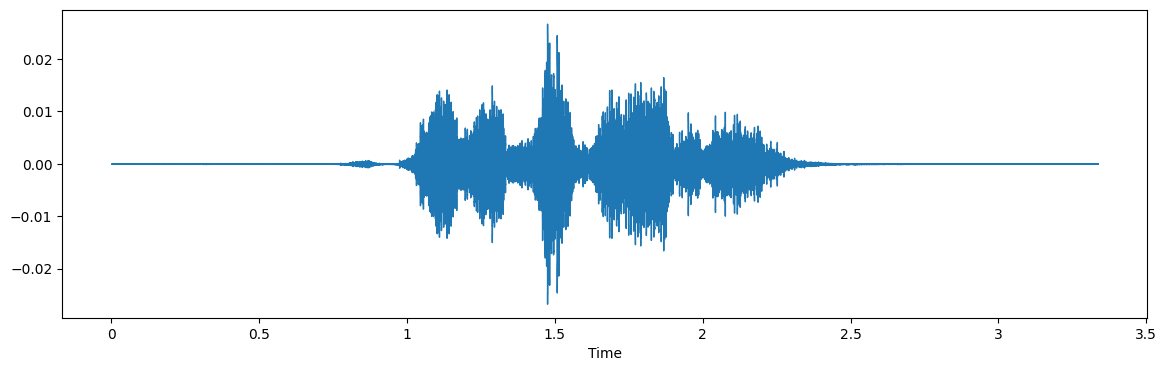

In [11]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [12]:

def extract_features(data, sample_rate):
    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    # Spectral Centroid
    spectral_centroids = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_centroids))

    # Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_bandwidth))

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff))

    # Chroma Deviation
    chroma_std = np.std(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_std))

    return result

def get_features(path):
    # TODO - Consider removing quiet parts of the audio before stitching the audio by 0.5 seconds lengths
    # This will require some calculations to get the duration and stepsize right
    
    hstack = None
    step = 5
    for i in range(0,30,step):
        
        if i == 0:
            offset=0
        else:
            i/=10
            offset = i-step/10
        print(i,offset)

        # Split audio according to the stepsize and offset
        data, sample_rate = librosa.load(path, offset=offset, duration=step/10)
        print(data)
    
        # without augmentation
        res1 = extract_features(data,sample_rate)
        result = np.array(res1)
        
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data,sample_rate)
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch,sample_rate)
        result = np.vstack((result, res3)) # stacking vertically
        
        if i == 0:
            hstack = result
        else: hstack = np.hstack((hstack,result))
        print(hstack.shape)
        
    return hstack

In [13]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

0 0
[ 5.3765390e-08 -2.1233145e-08 -6.0478342e-09 ... -9.7289310e-14
  5.3623948e-14  4.0833775e-13]
(3, 184)
0.5 0.0
[ 5.3765390e-08 -2.1233145e-08 -6.0478342e-09 ... -9.7289310e-14
  5.3623948e-14  4.0833775e-13]
(3, 368)
1.0 0.5
[ 1.6773167e-13 -1.4139693e-13 -1.6674535e-14 ... -2.4912157e-05
 -1.3756729e-05 -8.2513025e-06]
(3, 552)
1.5 1.0
[-3.1992196e-05 -8.7088993e-05 -8.2679748e-05 ...  5.9846533e-04
  6.0554000e-04  7.6285709e-04]
(3, 736)
2.0 1.5
[0.00071081 0.00174738 0.00291066 ... 0.00209488 0.00219533 0.00288344]
(3, 920)
2.5 2.0
[ 2.0491257e-03  3.5165688e-03  3.7435028e-03 ... -4.3936745e-07
  3.6242292e-07 -2.9281787e-07]
(3, 1104)
0 0
[-2.6555711e-06 -1.2237584e-05 -9.1077754e-07 ... -2.1457981e-06
  1.3691682e-05  2.3177893e-06]
(3, 184)
0.5 0.0
[-2.6555711e-06 -1.2237584e-05 -9.1077754e-07 ... -2.1457981e-06
  1.3691682e-05  2.3177893e-06]
(3, 368)
1.0 0.5
[ 1.0144345e-06 -2.3722143e-06  1.1701193e-05 ...  6.8651119e-05
  4.8622052e-05  5.9911799e-05]
(3, 552)
1.5 1.

(3, 552)
1.5 1.0
[-3.3501914e-04  1.3862663e-03  7.5928474e-05 ...  4.1782418e-03
  1.4186068e-03 -1.3061138e-03]
(3, 736)
2.0 1.5
[-0.00398376 -0.00746185 -0.0086335  ...  0.00198269  0.00083028
  0.00028779]
(3, 920)
2.5 2.0
[ 2.9954058e-04  9.8563661e-04  2.0363289e-03 ... -1.0168200e-04
 -1.2150525e-04 -1.0726187e-05]
(3, 1104)
0 0
[-5.6487844e-13  3.0621469e-13 -1.0651686e-12 ... -1.6424949e-06
  1.1470081e-06 -8.6993714e-07]
(3, 184)
0.5 0.0
[-5.6487844e-13  3.0621469e-13 -1.0651686e-12 ... -1.6424949e-06
  1.1470081e-06 -8.6993714e-07]
(3, 368)
1.0 0.5
[ 2.9034015e-09  7.8129476e-09 -1.6486585e-08 ...  1.0983649e-05
 -8.8221777e-06 -4.2497086e-06]
(3, 552)
1.5 1.0
[ 1.3607027e-05 -3.1950327e-05 -1.7518334e-05 ...  1.3662543e-02
  1.3562002e-02  1.6958045e-02]
(3, 736)
2.0 1.5
[0.01337484 0.02137554 0.01691358 ... 0.00108228 0.00082939 0.00099811]
(3, 920)
2.5 2.0
[ 0.00140658  0.00287142  0.00275141 ... -0.00272189 -0.00249202
 -0.00182656]
(3, 1104)
0 0
[ 4.4452278e-13  3.40092

(3, 552)
1.5 1.0
[0.00098714 0.00151253 0.00120179 ... 0.00472427 0.00445264 0.00341318]
(3, 736)
2.0 1.5
[ 0.00108008  0.00046127 -0.00084556 ...  0.01377548  0.01264459
  0.01324733]
(3, 920)
2.5 2.0
[0.00804597 0.01227921 0.00973715 ... 0.00061381 0.00200319 0.00379576]
(3, 1104)
0 0
[ 1.01835678e-08 -1.00502096e-08  9.52424273e-09 ... -2.46796737e-14
 -1.96301681e-14  1.34427491e-14]
(3, 184)
0.5 0.0
[ 1.01835678e-08 -1.00502096e-08  9.52424273e-09 ... -2.46796737e-14
 -1.96301681e-14  1.34427491e-14]
(3, 368)
1.0 0.5
[ 8.7619074e-14  2.5176202e-13  5.7471348e-14 ... -1.0658016e-05
 -5.7305875e-05 -4.5230918e-05]
(3, 552)
1.5 1.0
[-8.5311331e-06 -1.7968725e-05 -3.8883089e-05 ...  1.8693418e-03
  1.7627371e-03  1.6309312e-03]
(3, 736)
2.0 1.5
[0.00086056 0.00137982 0.00121069 ... 0.00912246 0.00729805 0.00441932]
(3, 920)
2.5 2.0
[ 1.0473962e-03 -2.9885196e-05 -7.8002206e-04 ...  3.3937194e-03
  1.7565360e-03  7.5414276e-04]
(3, 1104)
0 0
[ 2.5741610e-13 -5.1603666e-14 -1.6343528e-1

(3, 552)
1.5 1.0
[-0.00016079 -0.00018153 -0.00015269 ...  0.00858073 -0.00370547
 -0.00345891]
(3, 736)
2.0 1.5
[ 0.00313428 -0.00488035 -0.0055798  ... -0.00137778 -0.00145402
 -0.00198993]
(3, 920)
2.5 2.0
[-1.2507766e-03 -2.3226202e-03 -2.2861916e-03 ... -4.4585970e-05
 -5.3852807e-05 -9.0543763e-05]
(3, 1104)
0 0
[ 7.5794839e-14 -1.2690780e-13  3.0018259e-13 ...  1.2274449e-05
  4.5005795e-06 -2.1611854e-06]
(3, 184)
0.5 0.0
[ 7.5794839e-14 -1.2690780e-13  3.0018259e-13 ...  1.2274449e-05
  4.5005795e-06 -2.1611854e-06]
(3, 368)
1.0 0.5
[-1.2035090e-07  3.9293400e-07 -7.1869857e-07 ...  7.5872566e-05
 -2.8455306e-06  2.1844162e-06]
(3, 552)
1.5 1.0
[ 1.2532634e-05  1.7553027e-06 -2.9013067e-06 ... -1.8544888e-04
  2.3223678e-05 -9.4741998e-05]
(3, 736)
2.0 1.5
[-3.2659838e-05 -8.4990897e-05  2.5705129e-04 ...  5.0061401e-03
  5.6855092e-03  6.8156943e-03]
(3, 920)
2.5 2.0
[0.00491354 0.00898904 0.00892056 ... 0.00075372 0.00507104 0.00948113]
(3, 1104)
0 0
[3.0858984e-04 4.5789825

(3, 552)
1.5 1.0
[-9.12625239e-07  2.67743258e-06 -1.37383995e-05 ... -2.08965130e-02
 -1.77119430e-02 -1.87301002e-02]
(3, 736)
2.0 1.5
[-0.01299326 -0.01645009 -0.00696016 ...  0.0312188   0.01419771
 -0.04332434]
(3, 920)
2.5 2.0
[ 0.04106043  0.02255941 -0.03725697 ...  0.00136985  0.000763
  0.00031986]
(3, 1104)
0 0
[ 2.0952140e-08 -2.8945083e-08  3.4449108e-08 ... -6.5085402e-08
  5.7633411e-08 -4.9904088e-08]
(3, 184)
0.5 0.0
[ 2.0952140e-08 -2.8945083e-08  3.4449108e-08 ... -6.5085402e-08
  5.7633411e-08 -4.9904088e-08]
(3, 368)
1.0 0.5
[-3.8105529e-13 -1.4571830e-13  1.4283175e-13 ...  9.6672250e-07
 -8.2855632e-07  6.9020172e-07]
(3, 552)
1.5 1.0
[ 1.0139383e-06 -8.9328296e-09 -8.8336092e-06 ...  1.7087233e-03
  9.4448321e-04 -6.5488246e-05]
(3, 736)
2.0 1.5
[-0.00066598 -0.00130456 -0.0008752  ...  0.00191271  0.00180823
  0.0021642 ]
(3, 920)
2.5 2.0
[ 1.3023934e-03  1.6727616e-03  1.4561408e-03 ... -6.7431320e-05
 -2.7944317e-05  1.3076416e-05]
(3, 1104)
0 0
[ 1.8577642e-

C:\Users\ssyda\Downloads\IS213-main\is460-g2\mla-env\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(3, 736)
2.0 1.5
[-0.00208362 -0.00372468 -0.00346799 ... -0.00319195 -0.00301307
 -0.00332596]
(3, 920)
2.5 2.0
[-0.00214478 -0.00323702 -0.00288592 ...  0.00182811  0.00146988
  0.00101279]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[9.2457932e-15 9.3688939e-14 4.6156621e-15 ... 4.2644009e-05 2.7379869e-05
 2.7289310e-05]
(3, 552)
1.5 1.0
[ 3.3889737e-05  5.7353682e-05  5.3596337e-05 ... -1.9323230e-03
  6.5055402e-04  2.4087320e-03]
(3, 736)
2.0 1.5
[ 9.8803523e-04  9.2546165e-04 -8.7017354e-05 ... -5.4617450e-03
 -4.1930215e-03 -2.1911729e-03]
(3, 920)
2.5 2.0
[ 2.8565939e-04  2.2812127e-03  3.7969430e-03 ... -1.6652430e-04
 -1.8629566e-05  2.2444502e-04]
(3, 1104)
0 0
[-3.08700344e-14  1.37443130e-13 -1.13273160e-13 ...  1.94110669e-07
  2.93821131e-07 -1.31166835e-05]
(3, 184)
0.5 0.0
[-3.08700344e-14  1.37443130e-13 -1.13273160e-13 ...  1.94110669e-07
  2.93821131e-07 -1.31166835e-05]
(3, 368)
1.0 0.5
[ 2.5463476e-07 -3.455772

(3, 736)
2.0 1.5
[ 0.00243584  0.00239387 -0.00043153 ... -0.00013083 -0.00081414
 -0.00207069]
(3, 920)
2.5 2.0
[-0.00201671 -0.00384082 -0.00417146 ... -0.00687499 -0.00709989
 -0.00840128]
(3, 1104)
0 0
[ 3.8419294e-09 -2.5777163e-09  1.3687957e-09 ... -2.6249143e-07
  2.4159809e-07 -2.1948483e-07]
(3, 184)
0.5 0.0
[ 3.8419294e-09 -2.5777163e-09  1.3687957e-09 ... -2.6249143e-07
  2.4159809e-07 -2.1948483e-07]
(3, 368)
1.0 0.5
[ 2.5702360e-07 -2.4156179e-07  2.1871668e-07 ...  1.0214214e-06
  2.5794884e-07 -1.3363592e-05]
(3, 552)
1.5 1.0
[ 9.8169994e-07 -7.8828762e-06 -2.0131480e-05 ... -1.8514305e-02
 -1.4693770e-03  1.0806669e-02]
(3, 736)
2.0 1.5
[ 0.01035329  0.01845538  0.01844416 ... -0.00787618 -0.00806771
 -0.00968386]
(3, 920)
2.5 2.0
[-0.00668337 -0.0109981  -0.0107465  ... -0.00902244 -0.00806068
 -0.0068514 ]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[-9.5605125e-15 -3.9844931e-13  8.1486196e-15 ... -2.8228456e-05
 -

(3, 552)
1.5 1.0
[ 9.2492082e-05  1.4133481e-04  8.4888663e-05 ...  5.8872961e-03
  1.9033967e-02 -8.8338787e-04]
(3, 736)
2.0 1.5
[-0.01665785 -0.00465327  0.02274899 ... -0.01666584 -0.01747514
 -0.02174473]
(3, 920)
2.5 2.0
[-0.01737439 -0.03248485 -0.03638804 ... -0.01262099 -0.01257542
 -0.01262438]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.1139194e-14
 -7.4496602e-14 -3.1092144e-16]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.1139194e-14
 -7.4496602e-14 -3.1092144e-16]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0409541e-05 5.0672905e-05
 9.4870054e-05]
(3, 552)
1.5 1.0
[ 5.55223523e-05  1.05758685e-04  8.12256621e-05 ... -2.19959579e-02
 -2.07855590e-02 -2.21586414e-02]
(3, 736)
2.0 1.5
[-0.014942   -0.01942373 -0.01853883 ... -0.01381715 -0.0140644
 -0.01600957]
(3, 920)
2.5 2.0
[-0.01008733 -0.01423396 -0.00930542 ... -0.0017844  -0.00405179
 -0.00696847]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5

(3, 368)
1.0 0.5
[ 7.3764699e-05  6.2650139e-04  3.2210961e-04 ...  1.5295233e-04
 -2.9163515e-05 -1.7552718e-04]
(3, 552)
1.5 1.0
[ 2.0072655e-05  2.8569889e-04  5.4772536e-04 ... -1.0549159e-02
  1.4386987e-02 -1.1775746e-02]
(3, 736)
2.0 1.5
[-0.00382805  0.00621463  0.00266859 ...  0.00371333  0.00399243
  0.0046837 ]
(3, 920)
2.5 2.0
[ 0.00419018  0.00800027  0.00849784 ... -0.0065616  -0.006142
 -0.00603818]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.23995615e-05
 -1.76478861e-05 -4.15855357e-05]
(3, 552)
1.5 1.0
[ 1.6956634e-05  5.0108915e-06 -3.6608420e-05 ... -5.3461269e-04
  3.0019917e-03  1.3197225e-03]
(3, 736)
2.0 1.5
[ 0.00029434  0.00297554  0.0025465  ... -0.00442538 -0.00547627
 -0.00667458]
(3, 920)
2.5 2.0
[-0.00405284 -0.00594298 -0.00673895 ...  0.00304278  0.00303376
  0.00352976]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  7.0481997e-0

(3, 1104)
0 0
[ 1.9146148e-08 -1.8727702e-08  1.7488230e-08 ... -1.1684508e-06
  1.1339376e-06 -1.0891268e-06]
(3, 184)
0.5 0.0
[ 1.9146148e-08 -1.8727702e-08  1.7488230e-08 ... -1.1684508e-06
  1.1339376e-06 -1.0891268e-06]
(3, 368)
1.0 0.5
[ 4.8836063e-07 -5.5188389e-07  2.7235546e-07 ... -2.8534168e-06
  1.7505354e-06 -1.1839388e-06]
(3, 552)
1.5 1.0
[-5.7992975e-07  1.3032916e-06 -3.7005257e-06 ...  1.7340016e-02
  1.0623068e-02 -1.5878135e-02]
(3, 736)
2.0 1.5
[-0.01362503  0.00677736  0.01924641 ...  0.01358718  0.01502952
  0.01967349]
(3, 920)
2.5 2.0
[0.01415    0.02194542 0.02062594 ... 0.0120412  0.0105248  0.00733305]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.2305784e-05
 -1.5604136e-06  4.6586786e-07]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.2305784e-05
 -1.5604136e-06  4.6586786e-07]
(3, 368)
1.0 0.5
[-1.52246059e-06  2.65853214e-06 -4.93739935e-06 ... -1.01446858e-05
 -1.52035345e-05 -2.25519652e-05]
(3, 552)
1.5 1.0


(3, 552)
1.5 1.0
[-5.5663982e-06  4.1161129e-05  5.5308130e-05 ...  4.9625844e-02
  4.0543556e-02  3.4050167e-02]
(3, 736)
2.0 1.5
[ 0.01731182  0.02861483  0.02468968 ... -0.01566174 -0.01732183
 -0.01786152]
(3, 920)
2.5 2.0
[-0.00885687 -0.00888132 -0.00547528 ...  0.01181857  0.00998312
  0.00879792]
(3, 1104)
0 0
[ 4.4796208e-05  5.8718033e-05  6.2844469e-05 ...  4.7063963e-08
 -4.8373277e-08  4.8467939e-08]
(3, 184)
0.5 0.0
[ 4.4796208e-05  5.8718033e-05  6.2844469e-05 ...  4.7063963e-08
 -4.8373277e-08  4.8467939e-08]
(3, 368)
1.0 0.5
[-2.62975118e-06 -1.22321180e-05 -1.12086514e-06 ...  2.70259079e-07
 -1.22735555e-05 -1.61421867e-05]
(3, 552)
1.5 1.0
[-2.2112034e-05 -4.6167297e-05 -5.7665475e-05 ...  4.6418709e-04
  6.3448824e-04  1.2581768e-03]
(3, 736)
2.0 1.5
[ 0.0003381   0.00085663  0.00218909 ... -0.00164146 -0.00342068
 -0.00824216]
(3, 920)
2.5 2.0
[-0.00707821 -0.01372568 -0.01461728 ... -0.01529225 -0.02194116
 -0.0354084 ]
(3, 1104)
0 0
[ 4.0483606e-04  1.1569489e-0

(3, 1104)
0 0
[-4.9048138e-04 -7.1257574e-04 -6.5627682e-04 ...  3.9975443e-05
  3.6732043e-05 -1.6257613e-06]
(3, 184)
0.5 0.0
[-4.9048138e-04 -7.1257574e-04 -6.5627682e-04 ...  3.9975443e-05
  3.6732043e-05 -1.6257613e-06]
(3, 368)
1.0 0.5
[ 1.9230289e-05  1.5148210e-05 -3.6673364e-06 ...  5.9299371e-05
  1.3672640e-05  2.7817183e-05]
(3, 552)
1.5 1.0
[-1.5724603e-05  3.6292789e-05  8.2798324e-05 ...  2.0653824e-03
  5.5327080e-05 -2.4384219e-02]
(3, 736)
2.0 1.5
[-0.00802388  0.01335075 -0.00392325 ... -0.00040897 -0.00033128
 -0.0002478 ]
(3, 920)
2.5 2.0
[-0.00017018 -0.00028872 -0.0002071  ...  0.01674534  0.02747427
  0.05323068]
(3, 1104)
0 0
[-2.6827894e-07 -1.4359990e-05 -2.9780676e-07 ...  2.8580660e-04
 -1.9682699e-03 -1.9629321e-03]
(3, 184)
0.5 0.0
[-2.6827894e-07 -1.4359990e-05 -2.9780676e-07 ...  2.8580660e-04
 -1.9682699e-03 -1.9629321e-03]
(3, 368)
1.0 0.5
[ 8.8134344e-05  8.6309208e-04 -7.0159178e-04 ...  3.3034106e-05
  4.2523629e-05  9.6575648e-05]
(3, 552)
1.5 1.0

(3, 1104)
0 0
[-1.2343859e-06  1.5603524e-06 -2.7877441e-06 ...  7.1342265e-06
 -3.4809273e-06  2.4096357e-06]
(3, 184)
0.5 0.0
[-1.2343859e-06  1.5603524e-06 -2.7877441e-06 ...  7.1342265e-06
 -3.4809273e-06  2.4096357e-06]
(3, 368)
1.0 0.5
[ 1.3272523e-07 -1.5774857e-07  1.7120816e-07 ... -3.2395023e-04
 -2.9380107e-04 -4.0149238e-04]
(3, 552)
1.5 1.0
[-0.00043857 -0.00055783 -0.00056363 ... -0.00700265  0.00642623
  0.00750372]
(3, 736)
2.0 1.5
[-0.00360634  0.00293421  0.00758969 ... -0.00852571 -0.00947008
 -0.00598111]
(3, 920)
2.5 2.0
[ 0.00129456  0.00142602 -0.00035899 ...  0.01869285  0.01183301
  0.0018973 ]
(3, 1104)
0 0
[ 1.1865968e-06 -1.5171870e-06  1.7742749e-06 ...  8.5257418e-10
 -7.0812789e-10  5.7271560e-10]
(3, 184)
0.5 0.0
[ 1.1865968e-06 -1.5171870e-06  1.7742749e-06 ...  8.5257418e-10
 -7.0812789e-10  5.7271560e-10]
(3, 368)
1.0 0.5
[-2.8732053e-08 -4.2142496e-08  1.0369796e-07 ...  1.2382275e-05
 -2.9310286e-06  3.6946192e-05]
(3, 552)
1.5 1.0
[-8.5570737e-06  

(3, 552)
1.5 1.0
[-1.6347249e-04 -1.5432811e-04 -4.8606213e-05 ... -2.1412686e-02
 -1.8200202e-02 -1.6718378e-02]
(3, 736)
2.0 1.5
[-0.00886701 -0.01147577 -0.00729325 ...  0.01301572  0.01567106
  0.01848054]
(3, 920)
2.5 2.0
[ 1.17983194e-02  1.75913461e-02  1.53311482e-02 ... -1.08674365e-04
 -1.76875801e-05 -1.68702481e-05]
(3, 1104)
0 0
[-1.5818914e-07  5.6798217e-07 -1.1266723e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-1.5818914e-07  5.6798217e-07 -1.1266723e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5055621e-04
  2.6216681e-05 -3.0124944e-04]
(3, 552)
1.5 1.0
[ 0.00044525  0.00066374  0.00034382 ... -0.0151511  -0.01080217
 -0.0082224 ]
(3, 736)
2.0 1.5
[-0.00436685 -0.00449976 -0.0010738  ...  0.00557355  0.00575429
  0.00649162]
(3, 920)
2.5 2.0
[ 0.00420912  0.00666251  0.00633935 ... -0.00066008 -0.00062866
 -0.0004609 ]
(3, 1104)
0 0
[ 9.1512986e-14 -4.6301716e-1

(3, 552)
1.5 1.0
[ 4.6768585e-07 -3.5156324e-07  2.4194679e-07 ... -2.1353299e-03
  7.4935774e-04  3.3851089e-03]
(3, 736)
2.0 1.5
[ 0.00100386  0.00091257 -0.00076703 ... -0.01901183 -0.01499817
 -0.00682985]
(3, 920)
2.5 2.0
[ 0.00329076  0.01268307  0.01744439 ... -0.00242224 -0.00040422
  0.001715  ]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6088211e-06
  2.1076903e-06  5.2097570e-05]
(3, 552)
1.5 1.0
[ 4.2547585e-05  6.6535620e-05  3.1346164e-05 ...  5.3449618e-03
 -3.3356785e-03 -4.7728964e-03]
(3, 736)
2.0 1.5
[-0.00025351  0.00280405  0.00167029 ...  0.00073738  0.00084901
  0.00105635]
(3, 920)
2.5 2.0
[ 0.00082463  0.001281    0.00099988 ... -0.00486549 -0.00388505
 -0.00340674]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.9723538e-05
 -4.9930812e-05 -2.1000495e-05]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.9723538e-05
 -

(3, 1104)
0 0
[-9.7236197e-10  1.9346906e-09 -2.7174238e-09 ... -8.1405007e-09
  3.7460355e-09  5.9686922e-11]
(3, 184)
0.5 0.0
[-9.7236197e-10  1.9346906e-09 -2.7174238e-09 ... -8.1405007e-09
  3.7460355e-09  5.9686922e-11]
(3, 368)
1.0 0.5
[-1.7964148e-07  3.3319878e-07 -4.8047411e-07 ... -2.3920870e-07
  4.4534204e-07 -6.1940170e-07]
(3, 552)
1.5 1.0
[-2.1906308e-06  2.2249160e-06 -2.6794162e-06 ...  2.4207490e-03
  1.4705672e-03  6.5895874e-05]
(3, 736)
2.0 1.5
[ 0.00011988  0.00082915  0.00127821 ... -0.00068656 -0.00070128
  0.0003261 ]
(3, 920)
2.5 2.0
[ 4.7507958e-04  9.4492786e-04  2.1996132e-04 ...  1.0764528e-05
  2.0270403e-05 -2.8043132e-06]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ...  0.00453552  0.00127086
 -0.00295941]
(3, 552)
1.5 1.0
[-0.00434958 -0.00223956  0.01291728 ... -0.0038217  -0.00321856
 -0.00499577]
(3, 736)
2.0 1.5
[-0.0022418  -0.00262318 -0.00237659 ... -0.00337

(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0085069e-14
  4.0591123e-15  1.4888293e-13]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0085069e-14
  4.0591123e-15  1.4888293e-13]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.01141637 -0.01795261
  0.01004214]
(3, 552)
1.5 1.0
[-6.7239860e-05 -1.1233668e-02  6.7339940e-03 ...  5.0938483e-03
 -9.6095223e-03  2.3581984e-02]
(3, 736)
2.0 1.5
[-0.00324484  0.00042023  0.00053835 ... -0.0438647  -0.03980628
 -0.04095013]
(3, 920)
2.5 2.0
[-0.02467784 -0.03400066 -0.02520636 ... -0.02571041 -0.00841613
 -0.02034   ]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.01226056 -0.00390635
  0.00668925]
(3, 552)
1.5 1.0
[ 0.00443724  0.00076005 -0.00424809 ... -0.00175945 -0.00325109
 -0.00431314]
(3, 736)
2.0 1.5
[-0.00279117 -0.00381061 -0.00185933 ...  0.04720557  0.04566973
  0.05072883]
(3, 92

(3, 736)
2.0 1.5
[-0.02117655  0.04481949 -0.03765245 ... -0.00182435  0.00143189
  0.00998261]
(3, 920)
2.5 2.0
[ 0.010792    0.02088354  0.02315331 ...  0.01093745 -0.00204579
 -0.01798776]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2412117e-06
  2.4857914e-06 -2.0642858e-05]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.2412117e-06
  2.4857914e-06 -2.0642858e-05]
(3, 368)
1.0 0.5
[-1.3531490e-05 -1.3757551e-07  8.6379941e-07 ...  1.3269173e-05
  3.0009385e-05  4.3476735e-05]
(3, 552)
1.5 1.0
[ 6.0527332e-06  1.1954368e-05 -7.5122466e-06 ... -7.4738479e-04
 -2.6756471e-03  1.3839053e-02]
(3, 736)
2.0 1.5
[-0.01018735  0.0003472   0.00594528 ... -0.02086346 -0.02280053
 -0.02678937]
(3, 920)
2.5 2.0
[-0.01858132 -0.02973049 -0.02758948 ... -0.02534759 -0.03101958
 -0.04160247]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.000000e+00 0.000000e+00 0.000000e+00 ... 6.731531e-05 3.668281e-

(3, 184)
0.5 0.0
[-2.0448918e-09  5.2996576e-09 -7.6553155e-09 ... -1.2967237e-05
 -3.9511697e-06  1.7284822e-06]
(3, 368)
1.0 0.5
[-2.1578098e-06  3.5512981e-06 -1.2866151e-05 ... -3.2120611e-04
 -3.2482488e-04  1.7148178e-04]
(3, 552)
1.5 1.0
[ 0.00056176  0.00067526 -0.00064334 ...  0.00460238  0.00436713
  0.0046888 ]
(3, 736)
2.0 1.5
[ 2.9589874e-03  4.4641909e-03  3.6969234e-03 ... -9.5045601e-05
  6.9878979e-06 -1.9458836e-05]
(3, 920)
2.5 2.0
[-1.3560292e-05  5.4774409e-07 -6.9724658e-05 ...  2.6539731e-04
  5.2838062e-04  9.6841762e-04]
(3, 1104)
0 0
[ 2.6968474e-11 -2.8370464e-11  4.9897468e-11 ...  3.5746831e-05
  2.5383506e-05  5.4566197e-05]
(3, 184)
0.5 0.0
[ 2.6968474e-11 -2.8370464e-11  4.9897468e-11 ...  3.5746831e-05
  2.5383506e-05  5.4566197e-05]
(3, 368)
1.0 0.5
[ 2.2801980e-05  4.6361187e-05  2.8781495e-05 ... -3.1744847e-05
  6.2166200e-06 -2.8426034e-06]
(3, 552)
1.5 1.0
[ 5.13867690e-07 -6.87833506e-07  8.02364184e-07 ... -1.19875964e-04
 -1.41820001e-05  2.357

(3, 736)
2.0 1.5
[7.50264735e-05 1.02075646e-04 1.04175524e-04 ... 4.09738272e-02
 4.12969328e-02 4.56205085e-02]
(3, 920)
2.5 2.0
[0.02667392 0.04095562 0.03036895 ... 0.00432666 0.0042561  0.00357612]
(3, 1104)
0 0
[-7.4407120e-07  7.0742658e-07 -6.5165091e-07 ... -2.0460529e-06
  1.5063354e-06 -1.1834420e-06]
(3, 184)
0.5 0.0
[-7.4407120e-07  7.0742658e-07 -6.5165091e-07 ... -2.0460529e-06
  1.5063354e-06 -1.1834420e-06]
(3, 368)
1.0 0.5
[-2.3511078e-07  2.9009726e-07 -3.2519571e-07 ... -9.1978367e-03
 -6.4489394e-03 -1.0545553e-02]
(3, 552)
1.5 1.0
[ 0.0015942   0.01618172  0.01823299 ... -0.0170513  -0.01988894
 -0.02398929]
(3, 736)
2.0 1.5
[-0.0155311  -0.02308796 -0.01938869 ... -0.0074854  -0.00665028
 -0.00364624]
(3, 920)
2.5 2.0
[ 0.00136176  0.00356103  0.00221505 ... -0.00235835 -0.00200617
 -0.00170728]
(3, 1104)
0 0
[-1.0907669e-04 -1.5387076e-04 -1.6211122e-04 ...  1.2709103e-04
  4.0197323e-05  1.9106246e-04]
(3, 184)
0.5 0.0
[-1.0907669e-04 -1.5387076e-04 -1.6211122e

(3, 736)
2.0 1.5
[-0.0364404  -0.06178768 -0.05916117 ... -0.04604098 -0.06258315
 -0.06090007]
(3, 920)
2.5 2.0
[-0.01524061  0.00188714  0.0339195  ... -0.0004107  -0.00045345
 -0.00086123]
(3, 1104)
0 0
[ 2.18648370e-06  1.28330175e-05  2.28063982e-07 ... -1.28686312e-04
 -1.29597989e-04 -1.20291443e-04]
(3, 184)
0.5 0.0
[ 2.18648370e-06  1.28330175e-05  2.28063982e-07 ... -1.28686312e-04
 -1.29597989e-04 -1.20291443e-04]
(3, 368)
1.0 0.5
[-5.2706302e-05 -9.0774105e-05  4.6874707e-06 ... -2.6047125e-04
 -1.7824525e-04  5.9220900e-05]
(3, 552)
1.5 1.0
[ 0.00143873  0.00632382  0.009487   ... -0.00160648 -0.00227412
 -0.00104994]
(3, 736)
2.0 1.5
[-0.00034811 -0.0009974  -0.00136376 ...  0.00834044  0.00692613
  0.00300656]
(3, 920)
2.5 2.0
[0.00022124 0.00085002 0.00512549 ... 0.00512631 0.00479543 0.00516665]
(3, 1104)
0 0
[-1.1448070e-05 -2.5820624e-05 -3.0236090e-05 ...  2.7516584e-05
  1.6197329e-05  3.6264359e-05]
(3, 184)
0.5 0.0
[-1.1448070e-05 -2.5820624e-05 -3.0236090e-05 ..

(3, 184)
0.5 0.0
[ 0.00036679  0.00048039 -0.00036543 ...  0.00111208  0.00139133
  0.00030378]
(3, 368)
1.0 0.5
[ 0.00038907  0.00016695  0.00088003 ... -0.00874791  0.01055899
  0.01900884]
(3, 552)
1.5 1.0
[-0.00686328 -0.01968892  0.00335599 ...  0.00649441 -0.02077935
 -0.04558337]
(3, 736)
2.0 1.5
[-0.02644946 -0.04219335 -0.03781094 ... -0.08654148 -0.08672966
 -0.08712624]
(3, 920)
2.5 2.0
[-4.9954407e-02 -6.5938607e-02 -3.2624606e-02 ...  3.2916651e-05
  1.4775871e-05  2.2916442e-05]
(3, 1104)
0 0
[ 3.1653057e-12 -3.2448798e-12  4.4288770e-13 ... -4.7760182e-05
 -4.6257053e-05 -2.7649279e-05]
(3, 184)
0.5 0.0
[ 3.1653057e-12 -3.2448798e-12  4.4288770e-13 ... -4.7760182e-05
 -4.6257053e-05 -2.7649279e-05]
(3, 368)
1.0 0.5
[-4.2444703e-05 -6.5504522e-05 -5.8886617e-05 ... -1.5353782e-03
 -2.6206693e-03 -5.5871997e-04]
(3, 552)
1.5 1.0
[ 7.6186180e-04  1.3659978e-03  8.3567598e-04 ...  1.9175053e-04
 -6.9778907e-06 -7.7442965e-05]
(3, 736)
2.0 1.5
[ 0.00034853  0.0001373  -0.0002

(3, 184)
0.5 0.0
[-2.2634826e-05 -4.7104775e-05 -2.8094462e-05 ... -3.4157307e-05
 -4.9539281e-05 -3.3698183e-05]
(3, 368)
1.0 0.5
[-1.5578058e-05 -3.4323675e-05 -4.5532499e-05 ...  4.7664164e-04
 -3.4260727e-03 -2.2444287e-03]
(3, 552)
1.5 1.0
[0.002144   0.00478099 0.0064239  ... 0.0005643  0.00040172 0.00031354]
(3, 736)
2.0 1.5
[ 0.00013425  0.00060787  0.00027316 ... -0.02171408 -0.02036633
 -0.01465938]
(3, 920)
2.5 2.0
[-0.00484656 -0.00871135 -0.00977904 ... -0.01114512 -0.00353318
  0.00397386]
(3, 1104)
0 0
[-1.8829391e-12  5.2086894e-12  3.4598409e-13 ...  3.4559689e-05
  1.4998499e-05  3.0737741e-05]
(3, 184)
0.5 0.0
[-1.8829391e-12  5.2086894e-12  3.4598409e-13 ...  3.4559689e-05
  1.4998499e-05  3.0737741e-05]
(3, 368)
1.0 0.5
[3.4218087e-05 4.9344671e-05 2.2885331e-05 ... 3.0187337e-04 3.1875295e-04
 2.8019812e-04]
(3, 552)
1.5 1.0
[ 8.7316894e-06  1.4656973e-04  2.8918343e-04 ... -9.9116461e-03
 -1.2446347e-02 -1.8264903e-02]
(3, 736)
2.0 1.5
[-0.01504134 -0.02783749 -0

(3, 184)
0.5 0.0
[-7.5147718e-06 -3.8597707e-05 -1.0607462e-04 ... -1.9223677e-08
  4.0656005e-08 -5.8184867e-08]
(3, 368)
1.0 0.5
[ 5.8729313e-07 -8.5719870e-07  1.1702077e-06 ... -3.6735012e-04
  1.0071350e-03 -4.1532321e-04]
(3, 552)
1.5 1.0
[-7.8732288e-04 -3.8141079e-04 -7.5922173e-05 ...  8.2025928e-03
  7.6603503e-03  7.7279089e-03]
(3, 736)
2.0 1.5
[0.00547264 0.00656112 0.00545055 ... 0.00017948 0.00065777 0.00123426]
(3, 920)
2.5 2.0
[0.00115191 0.00222291 0.00238669 ... 0.00046824 0.00040664 0.00053222]
(3, 1104)
0 0
[ 2.8117543e-05 -3.9128554e-07 -2.4798055e-05 ... -3.4850551e-08
  3.5538505e-08 -3.5281090e-08]
(3, 184)
0.5 0.0
[ 2.8117543e-05 -3.9128554e-07 -2.4798055e-05 ... -3.4850551e-08
  3.5538505e-08 -3.5281090e-08]
(3, 368)
1.0 0.5
[-2.7446131e-08  5.0547808e-08 -6.7211431e-08 ...  7.0429803e-04
  3.9065583e-03 -3.0688103e-03]
(3, 552)
1.5 1.0
[-0.0034975   0.0072877   0.00242171 ...  0.00351619  0.00038871
 -0.00141132]
(3, 736)
2.0 1.5
[ 0.00335867 -0.00354219  0.

(3, 736)
2.0 1.5
[-7.8975252e-04  9.2783244e-04 -2.6495953e-05 ...  1.3928892e-04
 -1.0314095e-03 -2.5906153e-03]
(3, 920)
2.5 2.0
[-0.00244844 -0.00454791 -0.00442726 ...  0.00042439  0.00040226
  0.00033794]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.9035435e-13
 -1.2665925e-12 -1.1907101e-14]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.9035435e-13
 -1.2665925e-12 -1.1907101e-14]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  6.8689784e-05
  1.1218412e-05 -1.1743230e-06]
(3, 552)
1.5 1.0
[ 1.5604480e-06 -1.6706971e-06  2.0069567e-06 ...  1.0601757e-03
  3.1903847e-03 -4.5061768e-03]
(3, 736)
2.0 1.5
[ 0.0004779   0.00060272  0.00017132 ... -0.00476589 -0.00498265
 -0.00580049]
(3, 920)
2.5 2.0
[-0.00379297 -0.00542863 -0.00400033 ...  0.0007373   0.00080733
  0.00084546]
(3, 1104)
0 0
[-1.3957263e-13 -3.1693940e-14  6.8304351e-15 ... -2.5074471e-05
  7.7988398e-06 -4.8886695e-06]
(3, 184)
0.5 0.0
[-1.3957263e-13 -

(3, 736)
2.0 1.5
[ 0.00285506  0.00294435 -0.0014694  ...  0.00611459  0.0341139
  0.04204708]
(3, 920)
2.5 2.0
[ 0.00797487 -0.01654406 -0.05209719 ... -0.05061097 -0.01583156
  0.01143926]
(3, 1104)
0 0
[ 3.3325901e-05  8.6815744e-05  4.0849663e-05 ... -4.9340480e-05
 -5.8882160e-05 -9.6893156e-05]
(3, 184)
0.5 0.0
[ 3.3325901e-05  8.6815744e-05  4.0849663e-05 ... -4.9340480e-05
 -5.8882160e-05 -9.6893156e-05]
(3, 368)
1.0 0.5
[-4.3870863e-05 -5.6654666e-05 -4.7752248e-05 ... -5.0298893e-04
 -1.2700136e-03 -4.5982827e-04]
(3, 552)
1.5 1.0
[ 0.00054616 -0.00040439 -0.00111015 ...  0.00030032  0.00030917
  0.0003629 ]
(3, 736)
2.0 1.5
[ 0.0002507   0.00033789  0.00018867 ... -0.00879    -0.00830563
 -0.00907592]
(3, 920)
2.5 2.0
[-0.00568587 -0.00854018 -0.00687993 ...  0.00612235  0.00565999
  0.0061451 ]
(3, 1104)
0 0
[ 5.0424956e-07 -6.0408229e-07 -2.4682300e-05 ...  4.6236531e-05
 -4.0917903e-06  1.6148659e-05]
(3, 184)
0.5 0.0
[ 5.0424956e-07 -6.0408229e-07 -2.4682300e-05 ...  4.6

(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.00101467 -0.00280139
 -0.00272574]
(3, 552)
1.5 1.0
[-0.00032571  0.00022596  0.00276496 ...  0.00050283  0.00028767
  0.00024222]
(3, 736)
2.0 1.5
[-0.00205418 -0.00365411 -0.00010357 ...  0.0008606   0.00028049
 -0.00059646]
(3, 920)
2.5 2.0
[-0.00041596 -0.00102885 -0.00154009 ... -0.01627801 -0.01226247
 -0.01103004]
(3, 1104)
0 0
[-3.8418739e-06  1.3573276e-05  1.9451543e-05 ...  5.1810048e-13
 -6.1487864e-13 -1.4427611e-13]
(3, 184)
0.5 0.0
[-3.8418739e-06  1.3573276e-05  1.9451543e-05 ...  5.1810048e-13
 -6.1487864e-13 -1.4427611e-13]
(3, 368)
1.0 0.5
[-2.0329186e-13  1.3534641e-14 -1.3389580e-13 ...  6.7350394e-03
 -5.4197391e-03 -6.8577304e-03]
(3, 552)
1.5 1.0
[ 0.00658051  0.00474846 -0.00621361 ...  0.00737789 -0.0225113
 -0.00275436]
(3, 736)
2.0 1.5
[-0.00226165  0.01093606  0.00569803 ... -0.00079933 -0.00066634
 -0.00060371]
(3, 920)
2.5 2.0
[-0.00034416 -0.0004828  -0.00019538 ...  0.00067304  0.0006761
  0.0

(3, 368)
1.0 0.5
[ 1.8395024e-06  1.2945252e-05  3.9481029e-07 ... -1.2647505e-03
 -7.7911757e-04 -1.5023269e-04]
(3, 552)
1.5 1.0
[ 0.00337284  0.00311386 -0.00282952 ... -0.00526102 -0.00621178
 -0.00334873]
(3, 736)
2.0 1.5
[ 0.00046604 -0.00126167 -0.00171781 ...  0.00178074  0.00139104
  0.00118294]
(3, 920)
2.5 2.0
[ 0.00053588  0.00074366  0.00032176 ...  0.00061263  0.00196119
 -0.00024656]
(3, 1104)
0 0
[ 5.27797310e-05  5.44005270e-05 -2.26208322e-05 ... -9.27363786e-08
  1.02081046e-07 -1.07784913e-07]
(3, 184)
0.5 0.0
[ 5.27797310e-05  5.44005270e-05 -2.26208322e-05 ... -9.27363786e-08
  1.02081046e-07 -1.07784913e-07]
(3, 368)
1.0 0.5
[-8.2084182e-07  8.4909766e-07 -8.3885027e-07 ...  1.0083635e-02
  1.0344290e-02  1.1080979e-02]
(3, 552)
1.5 1.0
[ 0.00698471  0.01056317  0.00912889 ... -0.00041767 -0.00328043
  0.00068318]
(3, 736)
2.0 1.5
[-5.0683593e-05  1.8462259e-03 -2.5340093e-03 ... -1.8729193e-05
 -1.2378982e-06 -7.4270290e-05]
(3, 920)
2.5 2.0
[-0.00017145 -0.0003

(3, 368)
1.0 0.5
[-1.0469283e-05 -1.3329836e-05  7.3249394e-06 ...  1.1505863e-05
  2.7066759e-05  3.8852075e-05]
(3, 552)
1.5 1.0
[ 2.5534511e-05  2.4394392e-06  5.5262866e-05 ...  1.8552112e-04
 -3.5899843e-04 -1.5270989e-03]
(3, 736)
2.0 1.5
[-0.00086718 -0.00093395 -0.00119479 ...  0.0054705   0.00482567
  0.0050615 ]
(3, 920)
2.5 2.0
[0.00339989 0.00538196 0.00515128 ... 0.00067397 0.0004976  0.00035741]
(3, 1104)
0 0
[ 1.0443630e-05 -1.1502809e-05 -3.5443500e-05 ... -3.7929140e-06
  2.4917604e-06 -1.6851648e-06]
(3, 184)
0.5 0.0
[ 1.0443630e-05 -1.1502809e-05 -3.5443500e-05 ... -3.7929140e-06
  2.4917604e-06 -1.6851648e-06]
(3, 368)
1.0 0.5
[ 4.2406787e-06 -5.9275197e-05 -1.7658883e-04 ...  1.1888323e-02
  2.0489560e-02 -3.3637802e-03]
(3, 552)
1.5 1.0
[-0.01654335 -0.01100271  0.00625519 ...  0.01800628  0.01840005
 -0.00180996]
(3, 736)
2.0 1.5
[-0.00391095 -0.02021027 -0.01834672 ... -0.00338347 -0.00404711
 -0.00366212]
(3, 920)
2.5 2.0
[-0.00214956 -0.0046759  -0.0015046  ..

(3, 368)
1.0 0.5
[-2.0866426e-06  9.6627391e-06  3.5261102e-05 ...  8.8999317e-05
  1.2391720e-04  1.5881451e-04]
(3, 552)
1.5 1.0
[8.13201332e-05 1.27185675e-04 1.08657274e-04 ... 1.04396064e-02
 2.98580192e-02 4.04630378e-02]
(3, 736)
2.0 1.5
[ 2.9678304e-02  5.0320689e-02  4.9496088e-02 ... -4.3864576e-03
  2.5196496e-06 -8.5852770e-03]
(3, 920)
2.5 2.0
[-0.00851571 -0.00322556  0.00902283 ...  0.00190535  0.00499199
  0.00359947]
(3, 1104)
0 0
[ 4.0386120e-05  9.2886810e-05  1.0423563e-04 ...  2.9625340e-07
 -3.1153436e-07  3.1774823e-07]
(3, 184)
0.5 0.0
[ 4.0386120e-05  9.2886810e-05  1.0423563e-04 ...  2.9625340e-07
 -3.1153436e-07  3.1774823e-07]
(3, 368)
1.0 0.5
[ 2.2118789e-07 -3.1510535e-07  3.8919342e-07 ...  1.5416181e-03
 -5.2968296e-04 -1.3959582e-03]
(3, 552)
1.5 1.0
[0.00646015 0.01253785 0.00193234 ... 0.00820789 0.02062288 0.03106233]
(3, 736)
2.0 1.5
[ 0.02115231  0.02686123  0.01588702 ... -0.00322016 -0.00441245
 -0.00741946]
(3, 920)
2.5 2.0
[-0.00646729 -0.01126

(3, 920)
2.5 2.0
[ 0.00056     0.01705101  0.02660995 ... -0.03307901 -0.03444856
 -0.05251759]
(3, 1104)
0 0
[-2.1875954e-14  2.2506414e-13 -1.3337280e-13 ...  3.4284280e-05
  4.6635181e-05  5.4098084e-05]
(3, 184)
0.5 0.0
[-2.1875954e-14  2.2506414e-13 -1.3337280e-13 ...  3.4284280e-05
  4.6635181e-05  5.4098084e-05]
(3, 368)
1.0 0.5
[ 1.4569387e-06 -9.8630007e-06 -5.3852833e-05 ...  9.0500545e-03
 -5.3775366e-03 -2.7008839e-02]
(3, 552)
1.5 1.0
[ 1.8165889e-03  8.4080836e-03  6.3957181e-05 ...  2.3500595e-02
 -2.1830201e-06 -7.2675790e-03]
(3, 736)
2.0 1.5
[-0.00355941  0.00487026  0.00923177 ... -0.0057633  -0.00668927
 -0.00806716]
(3, 920)
2.5 2.0
[-0.00651559 -0.00958701 -0.00715908 ... -0.00244271 -0.00296856
 -0.00353075]
(3, 1104)
0 0
[-5.6277223e-08  7.8351142e-08 -9.3179004e-08 ... -6.0983027e-08
  5.7082676e-08 -5.3569785e-08]
(3, 184)
0.5 0.0
[-5.6277223e-08  7.8351142e-08 -9.3179004e-08 ... -6.0983027e-08
  5.7082676e-08 -5.3569785e-08]
(3, 368)
1.0 0.5
[ 1.1234593e-07 -

(3, 920)
2.5 2.0
[-0.00101248 -0.00162918 -0.00172512 ...  0.00072331  0.00050743
  0.00080971]
(3, 1104)
0 0
[ 2.1913831e-13 -1.1140534e-13 -9.1959189e-14 ...  2.2397948e-05
  1.5411782e-05  1.5028449e-05]
(3, 184)
0.5 0.0
[ 2.1913831e-13 -1.1140534e-13 -9.1959189e-14 ...  2.2397948e-05
  1.5411782e-05  1.5028449e-05]
(3, 368)
1.0 0.5
[ 1.4541929e-06 -1.7949262e-06  2.8711356e-05 ...  2.3204455e-04
  1.6771651e-04  1.7365048e-04]
(3, 552)
1.5 1.0
[ 0.00013921  0.00020343  0.00014605 ...  0.00408495 -0.00194826
 -0.00083657]
(3, 736)
2.0 1.5
[ 0.00488207 -0.00200699  0.0008229  ... -0.00346304 -0.00402552
 -0.00569054]
(3, 920)
2.5 2.0
[-0.00454525 -0.00816356 -0.00782959 ...  0.00115184  0.00186177
  0.00229112]
(3, 1104)
0 0
[0.         0.         0.         ... 0.00046184 0.00044512 0.00031381]
(3, 184)
0.5 0.0
[0.         0.         0.         ... 0.00046184 0.00044512 0.00031381]
(3, 368)
1.0 0.5
[ 1.4527905e-04 -1.0734189e-05  3.8727710e-05 ... -1.4809519e-02
  7.9063661e-03  9.1

(3, 368)
1.0 0.5
[ 4.3321561e-05  5.7973986e-05  4.5490924e-05 ... -5.8970913e-05
 -3.3744873e-05  3.0663405e-06]
(3, 552)
1.5 1.0
[ 3.7950770e-06 -2.5845409e-05 -3.2421318e-05 ...  1.4700694e-03
 -1.3402409e-03 -2.5704368e-03]
(3, 736)
2.0 1.5
[-0.00169506  0.00158366 -0.00255781 ...  0.00244195  0.0022065
  0.0019938 ]
(3, 920)
2.5 2.0
[0.0011218  0.00150142 0.00118779 ... 0.00089518 0.0005763  0.00049005]
(3, 1104)
0 0
[-6.4061198e-05 -9.8350356e-05 -8.7758846e-05 ...  7.8086327e-05
  7.3751209e-05  9.4879593e-05]
(3, 184)
0.5 0.0
[-6.4061198e-05 -9.8350356e-05 -8.7758846e-05 ...  7.8086327e-05
  7.3751209e-05  9.4879593e-05]
(3, 368)
1.0 0.5
[4.9989751e-05 9.9448189e-05 8.6342523e-05 ... 8.8228089e-06 2.1311762e-05
 9.0064586e-06]
(3, 552)
1.5 1.0
[-8.4149792e-07  7.1938766e-06  4.5775894e-05 ...  2.6177545e-04
  1.4605846e-03 -2.6866000e-03]
(3, 736)
2.0 1.5
[-1.4303206e-03  1.7965428e-03 -6.4791180e-05 ...  3.4084176e-03
  3.3686645e-03  3.7006307e-03]
(3, 920)
2.5 2.0
[ 2.435071

(3, 368)
1.0 0.5
[ 0.00011267  0.00018567  0.00016211 ... -0.00443089 -0.00388348
 -0.00555895]
(3, 552)
1.5 1.0
[-0.00468873 -0.00592217 -0.00447424 ...  0.00134031  0.00127913
  0.00130395]
(3, 736)
2.0 1.5
[ 7.9720217e-04  1.1440718e-03  8.8731275e-04 ... -8.5024635e-04
  8.2860352e-05  3.4349742e-03]
(3, 920)
2.5 2.0
[ 0.00371021  0.00360768 -0.0002331  ...  0.00272489  0.00221656
  0.00189469]
(3, 1104)
0 0
[-2.6555329e-08  1.0658215e-07 -2.3248957e-07 ... -9.5836345e-05
 -7.5056349e-05 -9.4891031e-05]
(3, 184)
0.5 0.0
[-2.6555329e-08  1.0658215e-07 -2.3248957e-07 ... -9.5836345e-05
 -7.5056349e-05 -9.4891031e-05]
(3, 368)
1.0 0.5
[-4.5871304e-05 -7.6488250e-05 -6.9019850e-05 ...  4.1379064e-04
  2.7176557e-04 -2.4081112e-04]
(3, 552)
1.5 1.0
[ 5.5517321e-05  5.2445999e-04  4.9938576e-04 ...  2.2363965e-03
 -8.1748492e-04 -1.8717467e-03]
(3, 736)
2.0 1.5
[ 0.00205795  0.00158231 -0.00226642 ...  0.00368211  0.00343823
  0.00344768]
(3, 920)
2.5 2.0
[ 2.08524661e-03  2.98072305e-03

(3, 368)
1.0 0.5
[ 4.5806219e-12  7.2549041e-12  3.4821343e-13 ...  1.2566207e-05
  3.4284862e-05 -4.8236670e-06]
(3, 552)
1.5 1.0
[-1.2366258e-05 -4.3619959e-05 -1.1976242e-05 ...  3.5788819e-02
 -1.9583691e-02  5.4726335e-03]
(3, 736)
2.0 1.5
[ 0.01026427 -0.01170777  0.01506177 ... -0.057794   -0.06998959
 -0.0706501 ]
(3, 920)
2.5 2.0
[-0.0329818  -0.06101109 -0.07123752 ... -0.00123398 -0.00107399
 -0.00091795]
(3, 1104)
0 0
[0.00011908 0.00020297 0.00017772 ... 0.0002071  0.00016838 0.00016601]
(3, 184)
0.5 0.0
[0.00011908 0.00020297 0.00017772 ... 0.0002071  0.00016838 0.00016601]
(3, 368)
1.0 0.5
[7.48957536e-05 1.24885875e-04 1.16997035e-04 ... 4.15924529e-04
 3.54867254e-04 4.30661021e-04]
(3, 552)
1.5 1.0
[ 0.0003079   0.00045501  0.00056323 ...  0.00837029 -0.0004972
  0.00920589]
(3, 736)
2.0 1.5
[-0.00877629 -0.00403415  0.01365874 ... -0.01576614 -0.0283853
 -0.06115812]
(3, 920)
2.5 2.0
[-0.04362098 -0.04336084  0.01451509 ...  0.00065819  0.00264211
  0.00519898]
(3, 1

(3, 920)
2.5 2.0
[-0.00227664 -0.00245787 -0.00188742 ...  0.0017287   0.00194776
  0.00254506]
(3, 1104)
0 0
[-1.6192684e-05 -4.7874128e-05 -4.6548113e-05 ... -1.5853027e-07
  1.3774988e-07 -1.1686322e-07]
(3, 184)
0.5 0.0
[-1.6192684e-05 -4.7874128e-05 -4.6548113e-05 ... -1.5853027e-07
  1.3774988e-07 -1.1686322e-07]
(3, 368)
1.0 0.5
[-9.2810178e-13  2.4018660e-12  6.3975821e-13 ...  5.0101433e-05
  2.5791060e-05  6.6666689e-05]
(3, 552)
1.5 1.0
[ 1.8520306e-05 -1.0832737e-06  3.1573298e-05 ... -1.8542102e-02
 -2.0307070e-02 -2.6473923e-02]
(3, 736)
2.0 1.5
[-0.02067185 -0.03267019 -0.02696747 ... -0.00110715 -0.00158094
 -0.00108021]
(3, 920)
2.5 2.0
[-0.00150355 -0.00073075  0.00148503 ... -0.01062809 -0.01068086
 -0.01025289]
(3, 1104)
0 0
[-9.1919583e-06 -8.5405754e-06 -1.4130403e-05 ... -6.9279660e-05
 -6.9485483e-05 -6.3626576e-05]
(3, 184)
0.5 0.0
[-9.1919583e-06 -8.5405754e-06 -1.4130403e-05 ... -6.9279660e-05
 -6.9485483e-05 -6.3626576e-05]
(3, 368)
1.0 0.5
[-5.6607976e-05 -

(3, 920)
2.5 2.0
[3.0686861e-04 4.9229979e-04 4.3621703e-04 ... 2.2593849e-05 2.7004049e-05
 5.3833093e-05]
(3, 1104)
0 0
[ 2.2281964e-05  3.1819211e-05  5.1825123e-06 ...  2.5039060e-07
 -2.0621194e-07  1.6683852e-07]
(3, 184)
0.5 0.0
[ 2.2281964e-05  3.1819211e-05  5.1825123e-06 ...  2.5039060e-07
 -2.0621194e-07  1.6683852e-07]
(3, 368)
1.0 0.5
[ 8.26383018e-10 -1.05670894e-09  1.23622379e-09 ...  1.07831605e-04
  2.26391450e-04  1.00994039e-04]
(3, 552)
1.5 1.0
[ 1.7819947e-04 -7.8934936e-06 -6.5137785e-05 ...  8.1941043e-04
  2.8131265e-04 -5.9010973e-04]
(3, 736)
2.0 1.5
[-0.00071165 -0.00167079 -0.00198025 ...  0.00058984  0.00047752
  0.00040293]
(3, 920)
2.5 2.0
[ 2.4026635e-04  2.7091138e-04  9.0236892e-05 ... -2.0319888e-07
  2.0723967e-07 -2.0628742e-07]
(3, 1104)
0 0
[-2.26030701e-13 -1.44150534e-13 -1.00718574e-13 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
(3, 184)
0.5 0.0
[-2.26030701e-13 -1.44150534e-13 -1.00718574e-13 ...  0.00000000e+00
  0.00000000e+00  0.

(3, 920)
2.5 2.0
[-0.01045757 -0.01485011 -0.00972332 ...  0.00410291  0.00282562
  0.0026854 ]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 1.4874968e-13 -2.9316789e-13 -8.1810508e-14 ...  1.6418198e-07
  4.4246940e-07 -1.3910795e-07]
(3, 552)
1.5 1.0
[2.2806676e-05 3.1714491e-05 2.9985474e-06 ... 2.1198706e-04 1.9866627e-04
 1.3149000e-03]
(3, 736)
2.0 1.5
[ 0.00191731 -0.00267089 -0.00158202 ...  0.00398512  0.0038118
  0.00393667]
(3, 920)
2.5 2.0
[ 2.5069360e-03  3.7394604e-03  3.2102561e-03 ...  3.1363692e-05
  1.0027034e-06 -5.8663460e-07]
(3, 1104)
0 0
[-3.9113708e-09  4.3763331e-09 -4.5673105e-09 ... -8.0921199e-09
  4.7638151e-09 -1.7877144e-09]
(3, 184)
0.5 0.0
[-3.9113708e-09  4.3763331e-09 -4.5673105e-09 ... -8.0921199e-09
  4.7638151e-09 -1.7877144e-09]
(3, 368)
1.0 0.5
[ 1.4203398e-06 -2.1374144e-06  4.5119059e-06 ... -1.4639480e-04
 -2.1796388e-04 -3.3364329e-04]
(3, 552)
1.5 1.0
[-0.00038384 -0.0006275  -0.00044687 .

(3, 920)
2.5 2.0
[-0.00038802 -0.00053004 -0.00038284 ... -0.00299133 -0.00307112
 -0.00385562]
(3, 1104)
0 0
[ 3.3556496e-08 -4.2230941e-08  4.7357602e-08 ... -7.5497490e-05
 -7.1872855e-05 -4.8689442e-05]
(3, 184)
0.5 0.0
[ 3.3556496e-08 -4.2230941e-08  4.7357602e-08 ... -7.5497490e-05
 -7.1872855e-05 -4.8689442e-05]
(3, 368)
1.0 0.5
[-4.3907279e-05 -4.1218776e-05 -4.5259341e-05 ...  2.1703308e-05
 -1.4576932e-03 -4.6873282e-04]
(3, 552)
1.5 1.0
[ 5.3839508e-04  2.9438001e-05 -6.6622254e-04 ... -2.5965535e-04
 -2.9322435e-04 -1.7268196e-04]
(3, 736)
2.0 1.5
[-1.3776660e-04 -5.5094126e-05  3.6068953e-04 ... -1.0139588e-03
 -8.8896690e-04 -8.5792365e-04]
(3, 920)
2.5 2.0
[-0.00050739 -0.0006969  -0.00056415 ... -0.00178529 -0.00170072
 -0.00182678]
(3, 1104)
0 0
[-4.0591079e-08  3.2890270e-08 -2.4938423e-08 ...  1.0980784e-07
 -7.3680035e-08  4.1415092e-08]
(3, 184)
0.5 0.0
[-4.0591079e-08  3.2890270e-08 -2.4938423e-08 ...  1.0980784e-07
 -7.3680035e-08  4.1415092e-08]
(3, 368)
1.0 0.5

(3, 920)
2.5 2.0
[-1.3243747e-03 -1.9787306e-03 -1.7177835e-03 ... -2.9499932e-05
 -1.1190646e-06  4.8473635e-07]
(3, 1104)
0 0
[3.3675056e-05 5.6600089e-05 6.3122563e-05 ... 9.7955670e-04 7.7533547e-04
 7.4722688e-04]
(3, 184)
0.5 0.0
[3.3675056e-05 5.6600089e-05 6.3122563e-05 ... 9.7955670e-04 7.7533547e-04
 7.4722688e-04]
(3, 368)
1.0 0.5
[0.00045874 0.00057134 0.00046533 ... 0.00328025 0.00423209 0.00324022]
(3, 552)
1.5 1.0
[ 8.4202754e-04 -1.7218341e-05 -1.9681687e-04 ...  1.5587120e-02
  1.5283801e-02  1.6514041e-02]
(3, 736)
2.0 1.5
[1.3653051e-02 2.9236479e-02 3.7920214e-02 ... 9.5273790e-06 2.6910951e-05
 2.7023565e-05]
(3, 920)
2.5 2.0
[-3.0549396e-05 -5.5406359e-05 -9.7253742e-06 ...  2.1536677e-04
  2.4632984e-04  2.7754463e-04]
(3, 1104)
0 0
[-3.0929033e-07  2.2171079e-07 -1.3651402e-07 ...  1.5272279e-06
 -5.5159771e-06 -2.4598576e-05]
(3, 184)
0.5 0.0
[-3.0929033e-07  2.2171079e-07 -1.3651402e-07 ...  1.5272279e-06
 -5.5159771e-06 -2.4598576e-05]
(3, 368)
1.0 0.5
[-1.34

(3, 920)
2.5 2.0
[ 2.4274754e-04  2.9486345e-04  1.6095064e-04 ...  5.7336797e-07
 -5.0589483e-07  4.3887061e-07]
(3, 1104)
0 0
[-3.504199e-14  9.337967e-15 -9.777164e-15 ...  0.000000e+00  0.000000e+00
  0.000000e+00]
(3, 184)
0.5 0.0
[-3.504199e-14  9.337967e-15 -9.777164e-15 ...  0.000000e+00  0.000000e+00
  0.000000e+00]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.7288396e-06
  4.1889225e-06 -1.5586791e-05]
(3, 552)
1.5 1.0
[-2.0523645e-05 -7.6635843e-05 -5.2251882e-05 ...  4.0755495e-03
  3.8704420e-03  4.0047336e-03]
(3, 736)
2.0 1.5
[ 2.5523186e-03  3.6388929e-03  3.1276708e-03 ...  2.7166621e-04
  1.3989220e-04 -9.1522525e-06]
(3, 920)
2.5 2.0
[-3.4112127e-05 -1.5400947e-04 -2.3572476e-04 ... -1.5976850e-05
  5.2816094e-06 -2.2251959e-05]
(3, 1104)
0 0
[-1.4285432e-05  2.3308094e-06 -1.1562706e-05 ... -2.4847964e-06
  1.8001807e-06 -1.3515952e-06]
(3, 184)
0.5 0.0
[-1.4285432e-05  2.3308094e-06 -1.1562706e-05 ... -2.4847964e-06
  1.8001807e-06 -1.35159

(3, 920)
2.5 2.0
[0.03232164 0.05342384 0.04645154 ... 0.01189847 0.01080144 0.00853834]
(3, 1104)
0 0
[ 1.7076856e-04  1.0638048e-04 -1.4799539e-04 ...  1.6750426e-04
 -4.4290307e-05 -6.9448040e-05]
(3, 184)
0.5 0.0
[ 1.7076856e-04  1.0638048e-04 -1.4799539e-04 ...  1.6750426e-04
 -4.4290307e-05 -6.9448040e-05]
(3, 368)
1.0 0.5
[-3.05072535e-06  1.12353184e-04  1.90782273e-04 ...  1.44492544e-04
  1.38065559e-04  1.54206675e-04]
(3, 552)
1.5 1.0
[ 0.00011117  0.00023794  0.00012558 ... -0.01901606 -0.01818302
 -0.02774811]
(3, 736)
2.0 1.5
[-0.02006285 -0.0272804  -0.02069292 ... -0.0089335  -0.01062701
 -0.01261517]
(3, 920)
2.5 2.0
[-0.00888972 -0.0152581  -0.01586909 ...  0.03067688  0.03048752
  0.0363583 ]
(3, 1104)
0 0
[-1.2709155e-05  8.5288548e-07  2.3300685e-05 ... -5.0639068e-05
  4.0132370e-05  1.0672657e-04]
(3, 184)
0.5 0.0
[-1.2709155e-05  8.5288548e-07  2.3300685e-05 ... -5.0639068e-05
  4.0132370e-05  1.0672657e-04]
(3, 368)
1.0 0.5
[-1.7987686e-05 -1.6030388e-04 -3.11

(3, 920)
2.5 2.0
[0.24278173 0.49288243 0.49624568 ... 0.01339523 0.00945745 0.00579155]
(3, 1104)
0 0
[-9.7167404e-06 -3.0528208e-05 -7.0623610e-06 ...  3.1276475e-05
  2.0073710e-05  6.1813727e-05]
(3, 184)
0.5 0.0
[-9.7167404e-06 -3.0528208e-05 -7.0623610e-06 ...  3.1276475e-05
  2.0073710e-05  6.1813727e-05]
(3, 368)
1.0 0.5
[2.1049274e-05 4.9823189e-05 4.0865059e-05 ... 1.7463217e-03 1.0602582e-03
 1.5762562e-04]
(3, 552)
1.5 1.0
[-2.2454467e-05 -4.6942016e-04 -7.9200196e-04 ...  4.0508178e-03
  1.2685604e-03  3.5610719e-04]
(3, 736)
2.0 1.5
[-0.00072133 -0.00451761 -0.00984118 ... -0.5586701  -0.5458842
 -0.52694833]
(3, 920)
2.5 2.0
[-0.3047509  -0.4075422  -0.33426762 ...  0.00794313  0.02878784
  0.01208134]
(3, 1104)
0 0
[6.0153609e-05 1.1197196e-04 8.1648323e-05 ... 3.1627740e-05 2.9247632e-05
 1.9567593e-05]
(3, 184)
0.5 0.0
[6.0153609e-05 1.1197196e-04 8.1648323e-05 ... 3.1627740e-05 2.9247632e-05
 1.9567593e-05]
(3, 368)
1.0 0.5
[-4.3029308e-07  2.4492985e-05  2.3400180e-

(3, 920)
2.5 2.0
[-0.00975436 -0.01421549  0.02711692 ... -0.03754469 -0.04172211
 -0.05393142]
(3, 1104)
0 0
[-3.3614771e-05  1.1137163e-04  1.6821950e-04 ...  3.2077667e-05
  3.8240338e-05  8.2524257e-06]
(3, 184)
0.5 0.0
[-3.3614771e-05  1.1137163e-04  1.6821950e-04 ...  3.2077667e-05
  3.8240338e-05  8.2524257e-06]
(3, 368)
1.0 0.5
[-2.1343070e-05 -6.1408900e-05 -9.4240531e-05 ... -5.2858159e-05
 -5.9084814e-05  5.0851093e-05]
(3, 552)
1.5 1.0
[ 3.5163033e-05  6.9537455e-05  1.8041792e-05 ... -2.4916032e-02
 -2.0989416e-02  2.4979752e-03]
(3, 736)
2.0 1.5
[-0.00294849  0.00123457 -0.00917724 ... -0.08156919 -0.0729766
 -0.05042955]
(3, 920)
2.5 2.0
[-0.00771321  0.04075348  0.09653535 ... -0.1102963  -0.09827434
 -0.09279449]
(3, 1104)
0 0
[1.0339787e-04 1.6706741e-04 1.5079821e-04 ... 4.5922397e-06 1.7059632e-05
 2.2322678e-05]
(3, 184)
0.5 0.0
[1.0339787e-04 1.6706741e-04 1.5079821e-04 ... 4.5922397e-06 1.7059632e-05
 2.2322678e-05]
(3, 368)
1.0 0.5
[9.9026129e-06 1.1680919e-05 6

(3, 920)
2.5 2.0
[-0.01323153 -0.02127864 -0.02007018 ... -0.01032108 -0.01293059
 -0.01836962]
(3, 1104)
0 0
[ 3.9791814e-08 -1.4844054e-05 -4.5138627e-06 ...  2.3731694e-05
  1.3846946e-05  2.2810667e-05]
(3, 184)
0.5 0.0
[ 3.9791814e-08 -1.4844054e-05 -4.5138627e-06 ...  2.3731694e-05
  1.3846946e-05  2.2810667e-05]
(3, 368)
1.0 0.5
[ 2.3603499e-05  2.2510263e-05 -4.5517127e-06 ...  5.4320255e-05
  1.2004515e-04  1.0107683e-04]
(3, 552)
1.5 1.0
[8.8049339e-05 1.5297151e-04 1.6342950e-04 ... 2.6679404e-02 2.6852084e-02
 3.4891263e-02]
(3, 736)
2.0 1.5
[ 0.02616094  0.04512554  0.04426106 ... -0.02896356 -0.02791742
 -0.03134427]
(3, 920)
2.5 2.0
[-0.02174991 -0.03586577 -0.03517486 ...  0.00173775  0.0015036
  0.00180828]
(3, 1104)
0 0
[ 1.3902577e-06 -2.0687717e-06  3.1847394e-06 ... -9.8784503e-06
 -2.8790109e-05 -4.5195120e-05]
(3, 184)
0.5 0.0
[ 1.3902577e-06 -2.0687717e-06  3.1847394e-06 ... -9.8784503e-06
 -2.8790109e-05 -4.5195120e-05]
(3, 368)
1.0 0.5
[-2.0098980e-05 -3.47060

(3, 920)
2.5 2.0
[3.4489818e-02 5.2133072e-02 3.7045643e-02 ... 1.8923689e-04 7.8575526e-05
 3.9850878e-05]
(3, 1104)
0 0
[8.7123790e-06 3.1716721e-05 4.5347333e-06 ... 4.2910091e-05 2.0027037e-05
 1.7395299e-05]
(3, 184)
0.5 0.0
[8.7123790e-06 3.1716721e-05 4.5347333e-06 ... 4.2910091e-05 2.0027037e-05
 1.7395299e-05]
(3, 368)
1.0 0.5
[ 1.6274915e-05  2.6277732e-05  2.7805040e-06 ...  1.4671695e-02
  2.8269035e-03 -6.6112871e-03]
(3, 552)
1.5 1.0
[-0.00361425 -0.01156447 -0.00028719 ...  0.00776884  0.01789599
  0.00460565]
(3, 736)
2.0 1.5
[-0.0042596  -0.01120291  0.00066219 ...  0.21569501  0.21371594
  0.23752397]
(3, 920)
2.5 2.0
[0.1554151  0.21375838 0.15676002 ... 0.07655878 0.07043881 0.06634212]
(3, 1104)
0 0
[-4.6660563e-05 -5.1344039e-05 -4.0730200e-05 ... -4.4014418e-04
 -1.7659389e-03 -1.3696998e-03]
(3, 184)
0.5 0.0
[-4.6660563e-05 -5.1344039e-05 -4.0730200e-05 ... -4.4014418e-04
 -1.7659389e-03 -1.3696998e-03]
(3, 368)
1.0 0.5
[-8.4128020e-05 -2.8884431e-04 -2.6880816e

(3, 920)
2.5 2.0
[-0.00079206 -0.00107649 -0.00065545 ...  0.00297133  0.00240366
  0.0021492 ]
(3, 1104)
0 0
[3.1444244e-05 6.1105573e-05 7.2622832e-05 ... 4.2446728e-12 2.1167514e-12
 5.1875032e-12]
(3, 184)
0.5 0.0
[3.1444244e-05 6.1105573e-05 7.2622832e-05 ... 4.2446728e-12 2.1167514e-12
 5.1875032e-12]
(3, 368)
1.0 0.5
[-2.9069052e-12 -4.2024127e-12 -9.4089823e-12 ...  1.8183750e-06
  2.9042803e-06  3.2400465e-05]
(3, 552)
1.5 1.0
[ 1.5566835e-05  6.0165217e-05  5.6948506e-05 ... -1.7593763e-04
 -1.8542928e-04 -3.7500734e-04]
(3, 736)
2.0 1.5
[-0.0002827  -0.00021783 -0.00015132 ...  0.0038913   0.00341779
  0.00320677]
(3, 920)
2.5 2.0
[1.7251688e-03 2.1477924e-03 1.4358507e-03 ... 9.2396527e-05 4.7976413e-05
 6.1160950e-05]
(3, 1104)
0 0
[-6.1972576e-05 -8.6171218e-05 -7.8772704e-05 ...  5.9898024e-12
 -4.8790711e-12 -2.7552734e-12]
(3, 184)
0.5 0.0
[-6.1972576e-05 -8.6171218e-05 -7.8772704e-05 ...  5.9898024e-12
 -4.8790711e-12 -2.7552734e-12]
(3, 368)
1.0 0.5
[-1.17584555e-07 

(3, 368)
1.0 0.5
[-3.2381868e-05 -5.3956708e-05 -3.4270150e-05 ... -2.4573397e-04
 -2.7138719e-04 -3.3113954e-04]
(3, 552)
1.5 1.0
[-0.00016935 -0.00033465 -0.00027025 ...  0.01590294  0.01362001
  0.01164189]
(3, 736)
2.0 1.5
[ 0.0056482   0.00915553  0.00860095 ... -0.0027983  -0.00297492
 -0.00383257]
(3, 920)
2.5 2.0
[-0.00261623 -0.00432548 -0.00457449 ... -0.00021803 -0.0002237
 -0.00020788]
(3, 1104)
0 0
[-2.0728113e-09 -2.4397502e-09  6.1464194e-09 ... -5.3452080e-05
 -2.0356438e-05 -4.4824003e-05]
(3, 184)
0.5 0.0
[-2.0728113e-09 -2.4397502e-09  6.1464194e-09 ... -5.3452080e-05
 -2.0356438e-05 -4.4824003e-05]
(3, 368)
1.0 0.5
[-2.4915807e-05 -3.4070315e-05 -5.1779003e-05 ... -7.3862757e-05
 -2.6383434e-04 -3.0443200e-04]
(3, 552)
1.5 1.0
[-0.00021985 -0.00029504  0.00011327 ... -0.03933747 -0.03793029
 -0.04116833]
(3, 736)
2.0 1.5
[-0.02722407 -0.04255712 -0.03594772 ...  0.03294422  0.03202291
  0.03365245]
(3, 920)
2.5 2.0
[ 0.02069179  0.02917375  0.02293801 ...  0.0019992

(3, 920)
2.5 2.0
[ 0.00293446  0.00194327 -0.00029127 ... -0.00033235 -0.0001363
 -0.00126344]
(3, 1104)
0 0
[ 1.5733665e-06  1.3832132e-05 -1.1393413e-06 ...  8.1165617e-06
  2.2585547e-05  1.9116374e-05]
(3, 184)
0.5 0.0
[ 1.5733665e-06  1.3832132e-05 -1.1393413e-06 ...  8.1165617e-06
  2.2585547e-05  1.9116374e-05]
(3, 368)
1.0 0.5
[ 1.08569857e-05  5.90083891e-06  1.79037761e-06 ... -1.13145597e-05
 -4.81449970e-05 -1.29294385e-05]
(3, 552)
1.5 1.0
[-2.7362950e-05 -1.9356243e-05 -1.9153737e-05 ... -1.7483184e-02
 -1.4252411e-02 -4.3453560e-03]
(3, 736)
2.0 1.5
[ 0.00127141  0.00459066 -0.00420624 ... -0.00762603 -0.01145029
 -0.01671525]
(3, 920)
2.5 2.0
[-1.2851240e-02 -2.2670202e-02 -2.2499822e-02 ... -2.5884087e-06
  1.7514965e-06 -1.3643971e-06]
(3, 1104)
0 0
[ 7.4883354e-07 -4.9408015e-07  1.0212339e-06 ... -4.0053044e-07
  3.7499314e-07 -3.4715683e-07]
(3, 184)
0.5 0.0
[ 7.4883354e-07 -4.9408015e-07  1.0212339e-06 ... -4.0053044e-07
  3.7499314e-07 -3.4715683e-07]
(3, 368)
1.

(3, 920)
2.5 2.0
[-0.00701082 -0.0118396  -0.01185269 ... -0.00814133 -0.00850293
 -0.00954273]
(3, 1104)
0 0
[ 1.8990308e-05  3.5831516e-05  2.5111818e-05 ... -7.7503273e-08
  9.4720257e-08 -1.0765867e-07]
(3, 184)
0.5 0.0
[ 1.8990308e-05  3.5831516e-05  2.5111818e-05 ... -7.7503273e-08
  9.4720257e-08 -1.0765867e-07]
(3, 368)
1.0 0.5
[-1.0253805e-07  6.2541538e-08 -2.7760208e-08 ...  7.8696746e-04
  3.8761864e-04  3.3137543e-04]
(3, 552)
1.5 1.0
[ 0.00022274  0.00045872  0.00057197 ...  0.00064371 -0.01017755
  0.01626514]
(3, 736)
2.0 1.5
[-6.1149476e-06 -1.4572991e-02  5.2104038e-03 ...  1.4593344e-02
  1.1720343e-02  9.5986165e-03]
(3, 920)
2.5 2.0
[0.00768351 0.01541808 0.01602506 ... 0.00554403 0.0069516  0.0097299 ]
(3, 1104)
0 0
[-2.5014811e-05 -2.0610856e-05  8.5542888e-07 ... -7.8491903e-06
 -1.6159873e-05 -2.2108106e-05]
(3, 184)
0.5 0.0
[-2.5014811e-05 -2.0610856e-05  8.5542888e-07 ... -7.8491903e-06
 -1.6159873e-05 -2.2108106e-05]
(3, 368)
1.0 0.5
[-9.4310508e-06 -7.32281

(3, 920)
2.5 2.0
[ 0.00185416  0.00273402  0.00234784 ... -0.00795609 -0.00819847
 -0.01004986]
(3, 1104)
0 0
[-3.9413260e-07  5.6726594e-07 -7.8858392e-07 ...  5.6657541e-09
  2.4836531e-08 -5.0605674e-08]
(3, 184)
0.5 0.0
[-3.9413260e-07  5.6726594e-07 -7.8858392e-07 ...  5.6657541e-09
  2.4836531e-08 -5.0605674e-08]
(3, 368)
1.0 0.5
[-3.0838765e-07  3.7231291e-07 -4.4223782e-07 ... -1.0581649e-04
 -1.5342439e-05  1.0455657e-05]
(3, 552)
1.5 1.0
[ 6.2164881e-06  1.2206465e-05 -4.4781282e-05 ...  5.1323569e-04
  4.9776502e-04  7.3258695e-04]
(3, 736)
2.0 1.5
[0.00056353 0.00098943 0.0011253  ... 0.00749419 0.00698198 0.00656025]
(3, 920)
2.5 2.0
[ 0.00367365  0.00467988  0.00306386 ... -0.00504932  0.00130961
  0.00400558]
(3, 1104)
0 0
[ 3.5489716e-09 -4.0553534e-09  4.3354600e-09 ... -3.2712669e-05
 -9.6308300e-05 -1.4022521e-04]
(3, 184)
0.5 0.0
[ 3.5489716e-09 -4.0553534e-09  4.3354600e-09 ... -3.2712669e-05
 -9.6308300e-05 -1.4022521e-04]
(3, 368)
1.0 0.5
[-4.2686162e-05 -1.90316

(3, 920)
2.5 2.0
[-0.02810483 -0.03858865 -0.03515179 ... -0.14354308 -0.1596624
 -0.16562708]
(3, 1104)
0 0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.0926988e-12 1.4036230e-12
 6.7769623e-13]
(3, 184)
0.5 0.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.0926988e-12 1.4036230e-12
 6.7769623e-13]
(3, 368)
1.0 0.5
[ 2.8552302e-13  8.0809518e-13 -9.1547852e-13 ...  2.3830860e-06
 -1.2052905e-06  7.0244005e-07]
(3, 552)
1.5 1.0
[-9.6122767e-07  6.3260171e-07 -3.3187791e-07 ... -9.2604876e-02
 -1.0934403e-01 -1.1229219e-01]
(3, 736)
2.0 1.5
[-0.06272382 -0.07335354 -0.0209619  ... -0.16318727 -0.13883545
 -0.09824792]
(3, 920)
2.5 2.0
[-0.01419855  0.04632581  0.13073434 ... -0.03663789 -0.03101245
 -0.02748986]
(3, 1104)
0 0
[-7.8246349e-14  1.4349770e-14  3.9091875e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-7.8246349e-14  1.4349770e-14  3.9091875e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 8.34807280e-14 -2.02977046e-

(3, 920)
2.5 2.0
[-0.0006955  -0.00098512 -0.00136334 ... -0.0041768  -0.00382154
 -0.00423991]
(3, 1104)
0 0
[ 9.3002363e-06  3.1199215e-05  5.0974281e-06 ...  2.0652851e-06
 -1.0393678e-06  5.7951951e-07]
(3, 184)
0.5 0.0
[ 9.3002363e-06  3.1199215e-05  5.0974281e-06 ...  2.0652851e-06
 -1.0393678e-06  5.7951951e-07]
(3, 368)
1.0 0.5
[ 3.49039829e-06 -1.16303445e-05 -6.86896055e-06 ... -1.30213914e-03
 -1.35481544e-03 -1.46430905e-03]
(3, 552)
1.5 1.0
[-0.0009968  -0.00158911 -0.00144225 ...  0.00392733  0.0064836
 -0.0045635 ]
(3, 736)
2.0 1.5
[-0.00389684  0.00608432  0.00277143 ... -0.0038444  -0.00366122
 -0.00390303]
(3, 920)
2.5 2.0
[-2.4970768e-03 -3.8022017e-03 -3.2941112e-03 ...  4.0792292e-03
  2.0645626e-03  4.4925458e-05]
(3, 1104)
0 0
[-6.4820052e-11  1.0884879e-10 -1.5064457e-10 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-6.4820052e-11  1.0884879e-10 -1.5064457e-10 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[-2.4968084e

(3, 368)
1.0 0.5
[ 1.9753749e-13 -9.4880462e-13 -7.5372976e-13 ...  5.2569541e-03
 -3.3263164e-03  4.4127889e-03]
(3, 552)
1.5 1.0
[ 0.00456381 -0.00163201 -0.00631753 ... -0.00319383 -0.00049804
 -0.00407147]
(3, 736)
2.0 1.5
[-0.0026996  -0.00544904  0.00133593 ...  0.00405908  0.00601924
  0.00577577]
(3, 920)
2.5 2.0
[ 0.00086034 -0.00366108 -0.00757903 ...  0.04608168  0.05994099
  0.08232825]
(3, 1104)
0 0
[ 4.0480449e-05  5.2563570e-05  5.8947306e-05 ... -7.9319608e-14
  1.9430829e-14 -2.2473736e-14]
(3, 184)
0.5 0.0
[ 4.0480449e-05  5.2563570e-05  5.8947306e-05 ... -7.9319608e-14
  1.9430829e-14 -2.2473736e-14]
(3, 368)
1.0 0.5
[-4.4759023e-14  8.4608800e-15 -7.0954256e-14 ... -4.1172743e-06
  1.9777397e-05  1.3779352e-05]
(3, 552)
1.5 1.0
[ 3.3791785e-06 -4.7323902e-06  7.9445163e-06 ...  1.0336600e-03
 -8.1254179e-03 -1.0821521e-03]
(3, 736)
2.0 1.5
[ 0.00033328 -0.00665383  0.00098511 ... -0.00802894 -0.00859602
 -0.01061437]
(3, 920)
2.5 2.0
[-0.0076903  -0.01264556 -0.0123

(3, 920)
2.5 2.0
[ 0.036787    0.05484394  0.02601255 ... -0.04633098 -0.04780065
 -0.05711954]
(3, 1104)
0 0
[-2.7320564e-08  2.9550851e-08 -2.9986666e-08 ...  4.2770167e-05
  2.8481580e-05  3.8107988e-05]
(3, 184)
0.5 0.0
[-2.7320564e-08  2.9550851e-08 -2.9986666e-08 ...  4.2770167e-05
  2.8481580e-05  3.8107988e-05]
(3, 368)
1.0 0.5
[3.6790017e-05 6.5669548e-05 5.9248505e-05 ... 9.3211147e-06 5.0763236e-05
 3.6356829e-05]
(3, 552)
1.5 1.0
[-1.6450947e-05 -1.3303883e-04 -1.2728164e-04 ...  4.2530168e-03
  7.6644751e-04 -6.7260386e-03]
(3, 736)
2.0 1.5
[ 0.00154299 -0.00254792 -0.00479167 ...  0.03386369  0.02853725
  0.02801611]
(3, 920)
2.5 2.0
[0.01620688 0.02037242 0.01200826 ... 0.01976923 0.01024121 0.00498484]
(3, 1104)
0 0
[ 3.3351484e-05  4.0240513e-05  5.0632931e-05 ... -5.2010542e-08
  6.8425400e-08 -8.0842085e-08]
(3, 184)
0.5 0.0
[ 3.3351484e-05  4.0240513e-05  5.0632931e-05 ... -5.2010542e-08
  6.8425400e-08 -8.0842085e-08]
(3, 368)
1.0 0.5
[ 3.6185543e-08 -4.2363439e-08

(3, 920)
2.5 2.0
[ 8.8161224e-04  1.2576480e-03  1.0482359e-03 ... -2.3849789e-06
  5.0929768e-05  2.5532352e-05]
(3, 1104)
0 0
[ 4.4179869e-05  5.6822024e-05  4.6947796e-05 ... -2.2618806e-05
 -3.1102874e-05 -1.8404775e-05]
(3, 184)
0.5 0.0
[ 4.4179869e-05  5.6822024e-05  4.6947796e-05 ... -2.2618806e-05
 -3.1102874e-05 -1.8404775e-05]
(3, 368)
1.0 0.5
[-1.2424347e-05 -2.4154808e-05 -3.2685162e-05 ... -1.2378205e-06
  1.2911561e-05  2.9961755e-06]
(3, 552)
1.5 1.0
[1.2769765e-05 3.6982859e-05 3.5446563e-05 ... 1.6489329e-03 2.9118801e-03
 4.7726911e-03]
(3, 736)
2.0 1.5
[ 0.00317135  0.00385275  0.00180952 ... -0.00346677 -0.00408843
 -0.00496923]
(3, 920)
2.5 2.0
[-3.1792421e-03 -4.6198107e-03 -3.3172346e-03 ... -5.7587276e-06
  2.4619003e-06 -1.6089917e-06]
(3, 1104)
0 0
[-4.4458687e-08  4.1878437e-08 -3.6372651e-08 ...  1.5919175e-06
 -7.6862261e-07 -1.2327432e-05]
(3, 184)
0.5 0.0
[-4.4458687e-08  4.1878437e-08 -3.6372651e-08 ...  1.5919175e-06
 -7.6862261e-07 -1.2327432e-05]
(3, 

(3, 920)
2.5 2.0
[-0.00177547 -0.00275461 -0.00241711 ... -0.00050471 -0.00046259
 -0.00053006]
(3, 1104)
0 0
[ 2.5207161e-12  2.1116104e-12  3.5539399e-12 ... -4.6923320e-05
 -2.1279666e-05 -9.1477341e-06]
(3, 184)
0.5 0.0
[ 2.5207161e-12  2.1116104e-12  3.5539399e-12 ... -4.6923320e-05
 -2.1279666e-05 -9.1477341e-06]
(3, 368)
1.0 0.5
[-2.0365792e-06 -1.3618253e-05  2.0200509e-06 ...  4.5695859e-05
  3.2419062e-05  4.5601701e-05]
(3, 552)
1.5 1.0
[ 3.0795352e-05  3.4443070e-05  5.4292483e-05 ... -5.8973413e-03
  4.4971216e-03 -2.8685143e-04]
(3, 736)
2.0 1.5
[ 0.00077167 -0.00241018  0.00304958 ... -0.00217489 -0.00147429
 -0.00124079]
(3, 920)
2.5 2.0
[-0.00056718 -0.00044678  0.00018362 ...  0.00012632  0.0001121
  0.00011867]
(3, 1104)
0 0
[-2.5445252e-05 -2.0129532e-05  2.1878441e-07 ... -6.6906970e-05
 -5.8829137e-05 -7.1579518e-05]
(3, 184)
0.5 0.0
[-2.5445252e-05 -2.0129532e-05  2.1878441e-07 ... -6.6906970e-05
 -5.8829137e-05 -7.1579518e-05]
(3, 368)
1.0 0.5
[-3.6928217e-05 -4

(3, 920)
2.5 2.0
[ 0.01297398  0.01594503 -0.02448775 ... -0.01567948 -0.01431562
 -0.01210077]
(3, 1104)
0 0
[ 3.2007754e-12  7.6602943e-12  5.7464003e-12 ... -1.1610253e-07
  1.2508087e-07 -1.3012198e-07]
(3, 184)
0.5 0.0
[ 3.2007754e-12  7.6602943e-12  5.7464003e-12 ... -1.1610253e-07
  1.2508087e-07 -1.3012198e-07]
(3, 368)
1.0 0.5
[-3.7130059e-07  2.5988183e-07 -1.5247161e-07 ... -1.2819582e-04
 -1.3909204e-04 -1.4837326e-04]
(3, 552)
1.5 1.0
[-7.5276308e-05 -1.9711134e-04 -1.7141658e-04 ...  2.5850935e-03
  2.6710411e-03  2.7319835e-03]
(3, 736)
2.0 1.5
[0.00172304 0.00251855 0.0017148  ... 0.01852112 0.01959596 0.02440538]
(3, 920)
2.5 2.0
[ 1.7850799e-02  2.8793430e-02  2.6653452e-02 ... -4.1974832e-05
 -6.2187086e-05 -1.5766156e-05]
(3, 1104)
0 0
[ 2.5121321e-05  2.6056801e-05  2.3404413e-05 ... -1.2684811e-04
 -1.4887677e-04 -1.5451454e-04]
(3, 184)
0.5 0.0
[ 2.5121321e-05  2.6056801e-05  2.3404413e-05 ... -1.2684811e-04
 -1.4887677e-04 -1.5451454e-04]
(3, 368)
1.0 0.5
[-9.36

(3, 920)
2.5 2.0
[-8.6310180e-04 -1.1855869e-03 -7.4661395e-04 ... -4.2121760e-06
  7.3525871e-06  1.0584519e-05]
(3, 1104)
0 0
[ 1.7215052e-05  3.8542395e-05  1.2780050e-05 ... -4.9781966e-06
 -2.5972648e-05 -2.3332892e-05]
(3, 184)
0.5 0.0
[ 1.7215052e-05  3.8542395e-05  1.2780050e-05 ... -4.9781966e-06
 -2.5972648e-05 -2.3332892e-05]
(3, 368)
1.0 0.5
[-1.1725131e-05 -1.8907387e-05 -8.8954775e-06 ...  5.8708707e-04
  5.1119924e-04  6.0939498e-04]
(3, 552)
1.5 1.0
[0.00035035 0.00060716 0.00055126 ... 0.00019067 0.00022009 0.00029998]
(3, 736)
2.0 1.5
[ 0.00029686  0.00056173  0.00052314 ... -0.00186842 -0.00213989
 -0.00293615]
(3, 920)
2.5 2.0
[-0.00219424 -0.00368675 -0.00350201 ... -0.00199095 -0.00337509
 -0.00514533]
(3, 1104)
0 0
[ 3.3888352e-08 -4.7991861e-08  5.7773857e-08 ...  5.2274959e-07
 -3.1875135e-07  1.6202003e-07]
(3, 184)
0.5 0.0
[ 3.3888352e-08 -4.7991861e-08  5.7773857e-08 ...  5.2274959e-07
 -3.1875135e-07  1.6202003e-07]
(3, 368)
1.0 0.5
[ 1.1810954e-06 -1.40891

(3, 920)
2.5 2.0
[ 1.4268477e-03  1.7777401e-03  1.4397239e-03 ... -1.9655523e-08
  2.0916055e-08 -2.1484444e-08]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.7649887e-06 8.8870611e-06
 2.9839297e-05]
(3, 552)
1.5 1.0
[-8.8180241e-07  2.0954687e-06 -4.4891385e-06 ... -4.3339917e-04
  4.4463144e-05  1.4020610e-03]
(3, 736)
2.0 1.5
[-0.00217256 -0.0048695   0.00416315 ... -0.00171472 -0.00166628
 -0.00187472]
(3, 920)
2.5 2.0
[-1.2362465e-03 -1.9045919e-03 -1.5183222e-03 ... -8.4302446e-06
 -9.5425594e-06  6.1692674e-07]
(3, 1104)
0 0
[-1.1795175e-13 -1.0097830e-13  3.9685516e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-1.1795175e-13 -1.0097830e-13  3.9685516e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.8276893e-06
 -1.2220441e-05  2.7949486e-06]
(3, 552)
1.5 1.0
[ 1.8595528e-06 -9.

(3, 368)
1.0 0.5
[0.         0.         0.         ... 0.00022104 0.00014178 0.00013049]
(3, 552)
1.5 1.0
[ 0.00016871  0.00028029  0.00016718 ...  0.016797   -0.01164665
 -0.04988077]
(3, 736)
2.0 1.5
[-0.0559718  -0.10223104 -0.09856639 ...  0.02066603  0.00927408
 -0.0211913 ]
(3, 920)
2.5 2.0
[-0.0286936  -0.05543511 -0.04877407 ...  0.09049842  0.11899973
  0.09930312]
(3, 1104)
0 0
[-6.4482938e-14 -2.5803446e-14  2.4911256e-15 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-6.4482938e-14 -2.5803446e-14  2.4911256e-15 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.5159709e-05
 -3.8831963e-06  2.3889725e-06]
(3, 552)
1.5 1.0
[ 3.3889017e-05  1.7962944e-05  5.2971154e-06 ...  1.2272700e-03
  8.1043839e-03 -1.7837026e-03]
(3, 736)
2.0 1.5
[0.00765804 0.0004223  0.00344781 ... 0.00273476 0.00517942 0.00884064]
(3, 920)
2.5 2.0
[ 0.00829608  0.01933628  0.02913209 ... -0.06795487 -0.07764626

(3, 920)
2.5 2.0
[ 0.00175622  0.00282857  0.0025981  ... -0.03921389 -0.03144305
 -0.02837534]
(3, 1104)
0 0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.3544296e-14 8.1744893e-14
 2.7930972e-14]
(3, 184)
0.5 0.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.3544296e-14 8.1744893e-14
 2.7930972e-14]
(3, 368)
1.0 0.5
[-1.7139934e-08  3.5789739e-08 -4.9815299e-08 ... -6.9137430e-04
 -6.2582572e-04 -5.2969181e-04]
(3, 552)
1.5 1.0
[-0.00030747 -0.00039335 -0.00025117 ... -0.02160553 -0.02592617
 -0.02793103]
(3, 736)
2.0 1.5
[-0.01816373 -0.02559153 -0.02098846 ...  0.01677078  0.0188665
  0.02077931]
(3, 920)
2.5 2.0
[ 0.01326456  0.0217782   0.02037584 ... -0.00251992 -0.01234396
 -0.01126537]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0900352e-05
  6.7286033e-05  1.5559074e-04]
(3, 552)
1.5 1.0
[ 7.0781818e-05  6.4233958e-05  4.1808296e-05 ... -1.4132112e-03
 -3.5724335e-03

(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.7553480e-05
  8.3494851e-06  2.9742918e-05]
(3, 552)
1.5 1.0
[-5.8072246e-06 -2.3239467e-05 -1.1855822e-05 ... -3.0788146e-03
 -1.3520668e-03 -6.4461638e-06]
(3, 736)
2.0 1.5
[-0.00177533 -0.00348301 -0.00253336 ...  0.00497827  0.00489329
  0.004413  ]
(3, 920)
2.5 2.0
[ 0.00184703  0.00181463 -0.00028104 ... -0.00940036 -0.00922967
 -0.00893494]
(3, 1104)
0 0
[-6.1823778e-07  1.0043165e-06 -1.6443630e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-6.1823778e-07  1.0043165e-06 -1.6443630e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.9293992e-07 2.9977318e-06
 3.9775685e-05]
(3, 552)
1.5 1.0
[-3.0561791e-06  5.8121786e-06  7.1492532e-06 ...  6.1640283e-03
  2.9913853e-03 -4.7657188e-04]
(3, 736)
2.0 1.5
[-0.00169356 -0.00271215 -0.00208781 ... -0.00548016 -0.00506647
 -0.00626272]
(3, 920)
2.5 2.0
[-0.00424097 -0.0075

(3, 368)
1.0 0.5
[-1.0680986e-05 -3.4313329e-05 -3.9840044e-05 ... -6.3759413e-05
 -8.3752428e-05 -7.8611913e-05]
(3, 552)
1.5 1.0
[-5.0258499e-05 -5.8018646e-05 -4.8676073e-05 ... -6.0001370e-03
 -7.8221802e-03 -1.0694668e-02]
(3, 736)
2.0 1.5
[-0.00797588 -0.01181814 -0.00884543 ...  0.00949504  0.01026201
  0.01155434]
(3, 920)
2.5 2.0
[0.00737086 0.01065926 0.00895273 ... 0.00013716 0.00016037 0.00013553]
(3, 1104)
0 0
[-9.8780774e-06 -6.9727284e-06 -2.6129697e-05 ... -2.2542048e-05
 -1.4485244e-05  3.4506202e-06]
(3, 184)
0.5 0.0
[-9.8780774e-06 -6.9727284e-06 -2.6129697e-05 ... -2.2542048e-05
 -1.4485244e-05  3.4506202e-06]
(3, 368)
1.0 0.5
[-5.1446779e-07  7.8630552e-07 -1.0447154e-06 ...  6.2816625e-06
 -5.9284580e-06  1.0383092e-05]
(3, 552)
1.5 1.0
[ 1.1244842e-06 -7.8345811e-06 -1.3040982e-05 ... -5.2369097e-03
 -3.1621680e-03  3.7096848e-04]
(3, 736)
2.0 1.5
[ 0.00539735  0.01231554  0.01584423 ... -0.00026155 -0.00089908
 -0.00159895]
(3, 920)
2.5 2.0
[-0.00113775 -0.00171

(3, 368)
1.0 0.5
[-1.1390525e-07  1.3598016e-07 -1.4807742e-07 ... -7.2985540e-06
  5.0748204e-06 -9.2263908e-06]
(3, 552)
1.5 1.0
[ 1.4691564e-06 -1.2773874e-06  8.0641712e-06 ... -4.0747032e-05
 -4.0289454e-04 -1.0924551e-03]
(3, 736)
2.0 1.5
[-0.00184473 -0.00441423 -0.00562562 ...  0.00488595  0.00628692
  0.00411103]
(3, 920)
2.5 2.0
[ 0.00135561 -0.00044025 -0.0010169  ... -0.00022097 -0.00023458
 -0.00015641]
(3, 1104)
0 0
[-3.3139459e-05 -3.4334840e-05 -2.8868362e-05 ... -2.7079714e-05
 -1.1111742e-06  3.1652883e-07]
(3, 184)
0.5 0.0
[-3.3139459e-05 -3.4334840e-05 -2.8868362e-05 ... -2.7079714e-05
 -1.1111742e-06  3.1652883e-07]
(3, 368)
1.0 0.5
[-1.2873631e-06 -2.0252510e-05 -2.0063417e-05 ... -1.6613667e-04
 -1.6906216e-04 -2.3096324e-04]
(3, 552)
1.5 1.0
[-0.00014134 -0.00024288 -0.00019465 ...  0.01280364  0.01143778
  0.00856283]
(3, 736)
2.0 1.5
[0.00791048 0.01289521 0.01281398 ... 0.00309628 0.00314286 0.0032019 ]
(3, 920)
2.5 2.0
[0.00184182 0.002348   0.00158119 ... 0

(3, 368)
1.0 0.5
[ 1.9683303e-06 -3.4371533e-06 -1.2532211e-05 ...  2.1631813e-05
 -7.0662309e-06  4.7439280e-06]
(3, 552)
1.5 1.0
[-2.0793987e-06 -1.4413596e-05  1.0952905e-05 ...  1.3972865e-03
 -6.6324412e-03  5.4207584e-03]
(3, 736)
2.0 1.5
[-0.00685008  0.0072414  -0.00372519 ...  0.01600634  0.02824743
  0.04513023]
(3, 920)
2.5 2.0
[ 0.0340044   0.05030873  0.03270421 ... -0.00261949 -0.00313957
 -0.00380103]
(3, 1104)
0 0
[-8.5413672e-07  1.9232543e-06 -1.0389310e-05 ...  2.3718511e-07
 -1.8022996e-07  1.2774890e-07]
(3, 184)
0.5 0.0
[-8.5413672e-07  1.9232543e-06 -1.0389310e-05 ...  2.3718511e-07
 -1.8022996e-07  1.2774890e-07]
(3, 368)
1.0 0.5
[-1.2717824e-06  1.4474225e-06 -1.5672281e-06 ...  1.9813606e-06
  1.8096867e-05  3.4638717e-05]
(3, 552)
1.5 1.0
[-5.6146700e-06  3.2971824e-05  5.4174165e-05 ... -2.2420580e-03
  3.8566757e-03 -7.0594554e-03]
(3, 736)
2.0 1.5
[ 0.00160102  0.00353414  0.00126749 ... -0.00231998 -0.00146219
 -0.00139341]
(3, 920)
2.5 2.0
[-0.00103317 -

(3, 368)
1.0 0.5
[ 8.3638617e-05  6.8524052e-05 -1.3726975e-05 ... -9.4918429e-04
 -1.0526449e-03  3.8024515e-04]
(3, 552)
1.5 1.0
[ 0.00234105  0.00499138  0.00415336 ... -0.00797726 -0.00634386
 -0.01031268]
(3, 736)
2.0 1.5
[-0.007065   -0.01290255 -0.00972064 ...  0.02035832  0.01892108
  0.01884775]
(3, 920)
2.5 2.0
[0.00819324 0.01017184 0.00650423 ... 0.0004651  0.000429   0.00080704]
(3, 1104)
0 0
[ 1.5146106e-04  2.2628788e-04  1.9153839e-04 ... -3.2754506e-05
 -6.2480889e-05 -3.6879945e-05]
(3, 184)
0.5 0.0
[ 1.5146106e-04  2.2628788e-04  1.9153839e-04 ... -3.2754506e-05
 -6.2480889e-05 -3.6879945e-05]
(3, 368)
1.0 0.5
[ 7.7836842e-07 -9.3722718e-07  9.0533086e-07 ... -4.0930290e-06
 -1.1021327e-05 -2.8928733e-05]
(3, 552)
1.5 1.0
[-3.2719585e-05 -3.0133177e-05 -2.6025928e-06 ... -9.0053678e-03
 -3.6374799e-03 -8.4163044e-03]
(3, 736)
2.0 1.5
[ 0.01716299  0.02556455  0.03046524 ... -0.02154787 -0.00504959
 -0.00824155]
(3, 920)
2.5 2.0
[-0.0071369  -0.00467716  0.01106816 ..

(3, 920)
2.5 2.0
[-0.01983509 -0.02350448 -0.01193323 ...  0.01563889  0.01420604
  0.01129489]
(3, 1104)
0 0
[-2.4661669e-05 -5.6762736e-05 -4.3581185e-05 ...  1.2800337e-08
 -9.2225330e-09  5.9769696e-09]
(3, 184)
0.5 0.0
[-2.4661669e-05 -5.6762736e-05 -4.3581185e-05 ...  1.2800337e-08
 -9.2225330e-09  5.9769696e-09]
(3, 368)
1.0 0.5
[-9.7147552e-09  7.7203355e-09 -5.4681579e-09 ... -6.3992022e-03
 -2.3523313e-03  3.9631259e-03]
(3, 552)
1.5 1.0
[ 0.00359343  0.00245833 -0.00106333 ... -0.01097484 -0.01159227
 -0.01154626]
(3, 736)
2.0 1.5
[-0.00017551  0.00577732  0.01024876 ... -0.01659336 -0.01699416
 -0.02126395]
(3, 920)
2.5 2.0
[-0.01400303 -0.02116014 -0.0151908  ... -0.00055249 -0.0008671
 -0.00114235]
(3, 1104)
0 0
[-2.2405527e-05 -3.1769443e-05 -4.6855107e-06 ...  1.4025914e-10
  4.5943038e-10 -9.4048536e-10]
(3, 184)
0.5 0.0
[-2.2405527e-05 -3.1769443e-05 -4.6855107e-06 ...  1.4025914e-10
  4.5943038e-10 -9.4048536e-10]
(3, 368)
1.0 0.5
[ 2.5638870e-12  5.3264121e-13  4.05

(3, 920)
2.5 2.0
[ 0.00079885  0.00155678  0.0017454  ... -0.00053833 -0.00064739
 -0.00077512]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.000000e+00  0.000000e+00  0.000000e+00 ... -1.473497e-04  1.297621e-05
 -3.259348e-05]
(3, 552)
1.5 1.0
[-0.00016917 -0.00024822 -0.00016125 ...  0.00628093  0.00068595
 -0.0084637 ]
(3, 736)
2.0 1.5
[ 0.0072547   0.00669979 -0.0148331  ...  0.00379775  0.0035687
  0.00366055]
(3, 920)
2.5 2.0
[ 0.00226956  0.00332748  0.00258584 ... -0.00200857 -0.00222579
 -0.00283567]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0551981e-06
  9.7820714e-07 -8.9821617e-07]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0551981e-06
  9.7820714e-07 -8.9821617e-07]
(3, 368)
1.0 0.5
[ 1.3244749e-08  3.9068446e-08 -7.9933741e-08 ... -4.0808204e-06
  1.4382616e-05  2.2753759e-06]
(3, 552)
1.5 1.0
[-3.8396098e-07  1.1132120e-06 -2.3244841e-06 ... -1.5717018e-03
 -1.51711

(3, 920)
2.5 2.0
[0.00201812 0.00295436 0.00226904 ... 0.00427943 0.00522645 0.00671972]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.5147315e-07
  8.2691298e-07 -7.9184099e-07]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.5147315e-07
  8.2691298e-07 -7.9184099e-07]
(3, 368)
1.0 0.5
[-5.6036747e-10  4.6225462e-10 -3.3368558e-10 ... -6.9660621e-07
  5.8052246e-06  1.1342627e-05]
(3, 552)
1.5 1.0
[ 8.1188073e-06  9.6372032e-06 -4.5673660e-06 ...  5.6460313e-03
 -1.4718680e-03 -7.8682490e-03]
(3, 736)
2.0 1.5
[-0.0042861  -0.00162595  0.0048059  ...  0.00220431  0.00222917
  0.00237662]
(3, 920)
2.5 2.0
[0.00142361 0.0022263  0.00190139 ... 0.00214456 0.00168994 0.00136627]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[-1.7305535e-12  2.6486205e-12  2.1386296e-12 ...  4.5486027e-05
  3.1803458e-05 -8.9594687e-06]
(3, 552)
1.5 1.0
[ 6.7022202e-06  3.5674817e-05  1.5992906e-05 ... -4.3468601e-0

(3, 920)
2.5 2.0
[ 0.04974384  0.07348687  0.05931127 ... -0.02186979 -0.00809525
 -0.01138191]
(3, 1104)
0 0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.9546979e-05 5.6981404e-05
 6.2722643e-06]
(3, 184)
0.5 0.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.9546979e-05 5.6981404e-05
 6.2722643e-06]
(3, 368)
1.0 0.5
[ 4.9349978e-07 -2.3748275e-05 -4.0988965e-05 ... -1.3250479e-04
 -8.2714934e-05 -1.4269433e-04]
(3, 552)
1.5 1.0
[-5.4183874e-05 -1.5497846e-04 -1.4738238e-05 ... -2.4759545e-04
 -1.3271670e-04 -7.3389179e-04]
(3, 736)
2.0 1.5
[-0.00019731 -0.00035946 -0.00039913 ... -0.07237079 -0.0763884
 -0.10235409]
(3, 920)
2.5 2.0
[-0.08679594 -0.13497809 -0.15253785 ... -0.08767472 -0.1263952
 -0.12308431]
(3, 1104)
0 0
[ 1.1442455e-05  2.3856801e-06 -4.3424834e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 1.1442455e-05  2.3856801e-06 -4.3424834e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.

(3, 920)
2.5 2.0
[-0.00168043  0.00046742  0.00062741 ...  0.00683694  0.00628354
  0.00666037]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  9.0098217e-07
  1.4863572e-06 -7.4265740e-06]
(3, 552)
1.5 1.0
[-3.6548357e-05 -2.2968463e-05  5.7251732e-06 ... -5.7555824e-03
  2.8268225e-04  1.3816734e-03]
(3, 736)
2.0 1.5
[-0.00644605 -0.010629   -0.00874756 ... -0.02897826 -0.02172305
 -0.01510018]
(3, 920)
2.5 2.0
[-0.00191158  0.00283983  0.01072122 ...  0.00035544  0.00039353
  0.00043842]
(3, 1104)
0 0
[ 0.000000e+00  0.000000e+00  0.000000e+00 ...  9.594543e-07 -7.901915e-07
  6.506541e-07]
(3, 184)
0.5 0.0
[ 0.000000e+00  0.000000e+00  0.000000e+00 ...  9.594543e-07 -7.901915e-07
  6.506541e-07]
(3, 368)
1.0 0.5
[-3.4463034e-07 -6.3827758e-07 -1.5870479e-05 ... -2.0353818e-04
 -3.4922449e-04 -4.7004997e-04]
(3, 552)
1.5 1.0
[-0.00042146 -0.00060718 -0.00052752 ... -0.00792586 -0.00443

(3, 920)
2.5 2.0
[ 0.02078233  0.02520992  0.01307619 ... -0.00033971 -0.00031766
 -0.00036552]
(3, 1104)
0 0
[-5.3421725e-05 -4.5987428e-05  7.0767360e-06 ... -4.2051361e-06
  1.7659509e-05  3.4484183e-05]
(3, 184)
0.5 0.0
[-5.3421725e-05 -4.5987428e-05  7.0767360e-06 ... -4.2051361e-06
  1.7659509e-05  3.4484183e-05]
(3, 368)
1.0 0.5
[2.7267472e-05 4.5629378e-05 1.8348761e-05 ... 1.7831979e-07 1.8884566e-05
 1.3822539e-05]
(3, 552)
1.5 1.0
[ 7.6725964e-06 -1.7342387e-05  2.5919751e-06 ...  1.1295192e-03
 -1.9184825e-03  4.8863259e-03]
(3, 736)
2.0 1.5
[-0.00079387 -0.00243716  0.00439451 ... -0.01011325 -0.01167382
 -0.01485264]
(3, 920)
2.5 2.0
[-0.01069065 -0.01675908 -0.0143394  ...  0.00035363  0.00036074
  0.00033029]
(3, 1104)
0 0
[-2.2795653e-06  1.0551994e-05  2.6041747e-05 ...  1.9299656e-05
 -6.9851449e-06  2.3365645e-05]
(3, 184)
0.5 0.0
[-2.2795653e-06  1.0551994e-05  2.6041747e-05 ...  1.9299656e-05
 -6.9851449e-06  2.3365645e-05]
(3, 368)
1.0 0.5
[ 1.00715151e-05  3.044

(3, 920)
2.5 2.0
[ 1.9419661e-03  2.8911768e-03  2.5693486e-03 ... -4.2718733e-05
 -2.2719795e-04 -7.4422127e-04]
(3, 1104)
0 0
[ 8.4297470e-05  1.3182932e-04  1.2403776e-04 ... -2.8334491e-05
 -1.4264526e-06 -5.3551808e-05]
(3, 184)
0.5 0.0
[ 8.4297470e-05  1.3182932e-04  1.2403776e-04 ... -2.8334491e-05
 -1.4264526e-06 -5.3551808e-05]
(3, 368)
1.0 0.5
[-3.8364335e-05 -8.0108046e-05 -5.0351828e-05 ...  1.4133365e-05
 -3.8794562e-05 -5.8851485e-05]
(3, 552)
1.5 1.0
[-0.00011147 -0.00010536 -0.00012395 ... -0.08280273 -0.07540797
 -0.07628154]
(3, 736)
2.0 1.5
[-0.04545425 -0.05197472 -0.01842203 ...  0.00088385 -0.0030971
  0.00353904]
(3, 920)
2.5 2.0
[0.00616073 0.00869863 0.00573566 ... 0.0019629  0.00140993 0.00100393]
(3, 1104)
0 0
[-0.00026394 -0.00021849  0.00012834 ... -0.00012819 -0.00037577
 -0.00043711]
(3, 184)
0.5 0.0
[-0.00026394 -0.00021849  0.00012834 ... -0.00012819 -0.00037577
 -0.00043711]
(3, 368)
1.0 0.5
[-3.0059964e-04 -5.1181286e-04 -4.0008692e-04 ...  9.5373689e

(3, 368)
1.0 0.5
[ 2.0459208e-09  3.8923709e-08 -7.0894153e-08 ... -6.9798509e-05
 -1.0079496e-04 -4.6538895e-05]
(3, 552)
1.5 1.0
[-7.6229117e-06 -3.2979187e-05 -5.5946723e-05 ...  9.4096093e-03
 -5.8373571e-03 -2.4962274e-02]
(3, 736)
2.0 1.5
[-0.02556029 -0.04436385 -0.04252931 ... -0.01089958 -0.01416797
 -0.01773357]
(3, 920)
2.5 2.0
[-0.01188486 -0.01634031 -0.01307126 ... -0.00180195 -0.00192071
 -0.00273499]
(3, 1104)
0 0
[-3.2527234e-05 -6.0865172e-05 -7.3351897e-05 ... -4.0278601e-06
 -1.0151918e-05 -5.2368073e-06]
(3, 184)
0.5 0.0
[-3.2527234e-05 -6.0865172e-05 -7.3351897e-05 ... -4.0278601e-06
 -1.0151918e-05 -5.2368073e-06]
(3, 368)
1.0 0.5
[-1.4279103e-06  2.1667693e-06 -4.5580737e-06 ...  1.3524988e-05
  2.5631116e-05  1.6289659e-05]
(3, 552)
1.5 1.0
[ 2.6735474e-05  2.5393521e-05  3.0405885e-05 ...  1.7609287e-02
  3.1563733e-04 -1.5541338e-02]
(3, 736)
2.0 1.5
[ 7.48890499e-03  5.69312368e-04 -3.77435354e-04 ... -1.17940872e-04
 -9.91029301e-05  1.06402746e-04]
(3, 920

(3, 920)
2.5 2.0
[-0.0483022  -0.05298133 -0.01150803 ...  0.04182197  0.04009103
  0.04380868]
(3, 1104)
0 0
[ 3.5105104e-06  1.1770736e-05  2.2655472e-06 ...  4.5807334e-03
 -1.4885925e-03 -5.4189493e-03]
(3, 184)
0.5 0.0
[ 3.5105104e-06  1.1770736e-05  2.2655472e-06 ...  4.5807334e-03
 -1.4885925e-03 -5.4189493e-03]
(3, 368)
1.0 0.5
[-0.00305464 -0.00028656  0.00110982 ...  0.000367    0.00039753
  0.00058203]
(3, 552)
1.5 1.0
[ 0.0003823   0.00063347  0.00056936 ... -0.01538158 -0.01984672
 -0.01460243]
(3, 736)
2.0 1.5
[-0.00437331 -0.02289056 -0.01409234 ...  0.21447754  0.20906256
  0.1905083 ]
(3, 920)
2.5 2.0
[0.1261846  0.2224207  0.24209347 ... 0.05512246 0.05259871 0.05726758]
(3, 1104)
0 0
[-3.0391708e-05 -6.4376160e-05 -6.0399354e-05 ... -8.0412770e-05
 -5.8348538e-05 -8.5627136e-05]
(3, 184)
0.5 0.0
[-3.0391708e-05 -6.4376160e-05 -6.0399354e-05 ... -8.0412770e-05
 -5.8348538e-05 -8.5627136e-05]
(3, 368)
1.0 0.5
[-5.5171353e-05 -1.0528565e-04 -8.7930966e-05 ...  7.2956856

(3, 920)
2.5 2.0
[ 0.01712934  0.01987936  0.00910749 ... -0.00201228 -0.00186537
 -0.00203488]
(3, 1104)
0 0
[5.1533712e-05 7.5698525e-05 7.0519796e-05 ... 2.5713030e-05 3.5336857e-06
 2.6036530e-05]
(3, 184)
0.5 0.0
[5.1533712e-05 7.5698525e-05 7.0519796e-05 ... 2.5713030e-05 3.5336857e-06
 2.6036530e-05]
(3, 368)
1.0 0.5
[ 1.3615024e-05  3.8454400e-05  3.1515337e-05 ...  5.0190116e-05
 -5.2275561e-04 -7.4361812e-04]
(3, 552)
1.5 1.0
[-0.00064975 -0.00085024 -0.00081876 ...  0.01007965  0.01197858
  0.01757028]
(3, 736)
2.0 1.5
[ 0.01531906  0.02116251  0.02095909 ... -0.05390352 -0.06084909
 -0.07897994]
(3, 920)
2.5 2.0
[-0.05980424 -0.08521306 -0.08515108 ... -0.00175542 -0.00170776
 -0.00178006]
(3, 1104)
0 0
[-7.4198302e-05 -2.7771552e-05  2.0422456e-05 ... -4.3675108e-04
  1.5638184e-04 -5.0679740e-04]
(3, 184)
0.5 0.0
[-7.4198302e-05 -2.7771552e-05  2.0422456e-05 ... -4.3675108e-04
  1.5638184e-04 -5.0679740e-04]
(3, 368)
1.0 0.5
[0.00069223 0.00079383 0.00256166 ... 0.0016695

(3, 920)
2.5 2.0
[-0.01051576 -0.01528961 -0.01207683 ...  0.00160283  0.00120748
  0.00145049]
(3, 1104)
0 0
[1.56344284e-13 1.08426357e-13 1.23750755e-13 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
(3, 184)
0.5 0.0
[1.56344284e-13 1.08426357e-13 1.23750755e-13 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
(3, 368)
1.0 0.5
[-6.2019908e-14  9.4493166e-14 -2.1701711e-13 ...  1.3848682e-04
  4.2363114e-04  7.5230419e-05]
(3, 552)
1.5 1.0
[-2.5991941e-04 -8.2577870e-05  3.3963588e-06 ... -1.3072306e-02
 -1.1449909e-02 -1.0163972e-02]
(3, 736)
2.0 1.5
[-0.00508308 -0.00586363 -0.00312193 ...  0.00166533  0.00171133
  0.00165525]
(3, 920)
2.5 2.0
[ 0.00120277  0.00192652  0.00171462 ... -0.00332476 -0.00332708
 -0.00380475]
(3, 1104)
0 0
[-3.09709533e-14 -1.33021315e-14 -3.79650840e-15 ... -1.74561103e-13
  1.15752311e-13  1.14216742e-13]
(3, 184)
0.5 0.0
[-3.09709533e-14 -1.33021315e-14 -3.79650840e-15 ... -1.74561103e-13
  1.15752311e-13  1.14216742e-13]
(3, 368)
1.0 0.5
[ 6.3

(3, 920)
2.5 2.0
[-0.004453   -0.00635308 -0.00470239 ...  0.00174628  0.00225736
  0.00389616]
(3, 1104)
0 0
[-2.9343747e-13  6.8941342e-13  9.2361340e-14 ... -1.4236386e-13
 -1.6736176e-13  7.6774985e-14]
(3, 184)
0.5 0.0
[-2.9343747e-13  6.8941342e-13  9.2361340e-14 ... -1.4236386e-13
 -1.6736176e-13  7.6774985e-14]
(3, 368)
1.0 0.5
[ 3.1538462e-14  1.3348441e-14 -1.6213286e-14 ... -1.4496083e-05
 -7.7953064e-06 -6.4226606e-07]
(3, 552)
1.5 1.0
[-3.23201020e-05 -1.03710125e-04 -3.05184512e-05 ...  2.79883179e-03
  2.63292866e-04 -2.49194261e-03]
(3, 736)
2.0 1.5
[-0.00195059  0.00461939 -0.00293408 ...  0.00116692  0.00110916
  0.00124724]
(3, 920)
2.5 2.0
[0.00080036 0.00121096 0.0007164  ... 0.0052784  0.00519406 0.0059339 ]
(3, 1104)
0 0
[ 1.8431728e-10 -2.7603353e-10  3.5740044e-10 ... -4.9372943e-07
  2.9878217e-07 -1.6155131e-07]
(3, 184)
0.5 0.0
[ 1.8431728e-10 -2.7603353e-10  3.5740044e-10 ... -4.9372943e-07
  2.9878217e-07 -1.6155131e-07]
(3, 368)
1.0 0.5
[-1.7051052e-09  2

(3, 920)
2.5 2.0
[-0.0023066   0.06892294 -0.05627193 ... -0.3223973  -0.4223305
 -0.48432368]
(3, 1104)
0 0
[ 1.0951276e-07 -2.0608559e-07  2.8665465e-07 ...  1.5129383e-13
 -1.0272779e-13  2.2232385e-14]
(3, 184)
0.5 0.0
[ 1.0951276e-07 -2.0608559e-07  2.8665465e-07 ...  1.5129383e-13
 -1.0272779e-13  2.2232385e-14]
(3, 368)
1.0 0.5
[ 1.4245148e-13  4.7632612e-13 -3.0501312e-13 ...  3.9960593e-03
  3.9263638e-03  4.4761067e-03]
(3, 552)
1.5 1.0
[ 0.00302403  0.00482143  0.00445281 ... -0.00118912 -0.00023502
 -0.00037711]
(3, 736)
2.0 1.5
[ 0.00025944 -0.00035863  0.0009218  ... -0.05493899  0.09637029
  0.19797194]
(3, 920)
2.5 2.0
[ 9.9459507e-02  9.4804943e-02  3.5305582e-02 ... -1.3048754e-03
 -8.9881319e-04 -2.9132600e-05]
(3, 1104)
0 0
[ 3.8088822e-13 -1.7468566e-13 -9.2812029e-14 ...  1.4575399e-04
  1.4449302e-04  7.6274002e-05]
(3, 184)
0.5 0.0
[ 3.8088822e-13 -1.7468566e-13 -9.2812029e-14 ...  1.4575399e-04
  1.4449302e-04  7.6274002e-05]
(3, 368)
1.0 0.5
[ 7.4772383e-05  1

(3, 920)
2.5 2.0
[-0.00152486 -0.00619042  0.00261634 ... -0.00327154 -0.00369206
 -0.00499154]
(3, 1104)
0 0
[ 2.2955969e-07 -2.2520176e-07  2.1115756e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 2.2955969e-07 -2.2520176e-07  2.1115756e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.3897292e-07
  5.1767038e-06 -8.8028412e-07]
(3, 552)
1.5 1.0
[7.9065467e-06 1.3923470e-05 2.8702107e-05 ... 1.8095551e-03 1.5510512e-03
 1.3735293e-03]
(3, 736)
2.0 1.5
[ 7.0667389e-04  1.0157127e-03  8.1483909e-04 ... -3.0989609e-06
 -1.0959091e-05  1.9954563e-05]
(3, 920)
2.5 2.0
[ 4.4275821e-06  4.6488334e-05 -4.8497910e-05 ...  2.2266194e-02
  2.2256151e-02  1.9041928e-02]
(3, 1104)
0 0
[ 6.1105892e-14 -1.3481149e-13 -1.1538763e-13 ... -4.2988325e-14
  1.4990957e-13  4.6977125e-15]
(3, 184)
0.5 0.0
[ 6.1105892e-14 -1.3481149e-13 -1.1538763e-13 ... -4.2988325e-14
  1.4990957e-13  4.6977125e-15]
(3, 

(3, 368)
1.0 0.5
[ 5.9802646e-10 -8.3421642e-10  1.0311931e-09 ... -5.3562049e-04
 -3.9855269e-04 -1.3193394e-04]
(3, 552)
1.5 1.0
[ 0.00010378  0.00020205  0.00010336 ... -0.01356727 -0.0123051
 -0.01021666]
(3, 736)
2.0 1.5
[-0.00564762 -0.00834872 -0.00805947 ... -0.00254729 -0.0026668
 -0.00360802]
(3, 920)
2.5 2.0
[-2.7397606e-03 -4.2405943e-03 -3.8390069e-03 ... -1.4756783e-07
  9.6205902e-08 -5.4888694e-08]
(3, 1104)
0 0
[ 3.6707000e-08 -4.9437869e-08  5.7441468e-08 ...  1.9494825e-04
  1.8978401e-04  2.0246310e-04]
(3, 184)
0.5 0.0
[ 3.6707000e-08 -4.9437869e-08  5.7441468e-08 ...  1.9494825e-04
  1.8978401e-04  2.0246310e-04]
(3, 368)
1.0 0.5
[ 0.00013979  0.00020171  0.00020445 ... -0.00119159 -0.00109366
 -0.00100803]
(3, 552)
1.5 1.0
[-0.00078589 -0.00135537 -0.00128058 ...  0.00256919  0.00122423
 -0.00047774]
(3, 736)
2.0 1.5
[-0.00088159 -0.00195969 -0.0025225  ... -0.00146254 -0.0014384
 -0.00152904]
(3, 920)
2.5 2.0
[-1.0444587e-03 -1.6950361e-03 -1.6914210e-03 ... -7.

(3, 368)
1.0 0.5
[-0.00015231 -0.00024141 -0.00020634 ...  0.0011912  -0.00048719
  0.00117217]
(3, 552)
1.5 1.0
[ 0.00107343  0.0001053  -0.0019649  ... -0.03049996 -0.02567279
 -0.02501165]
(3, 736)
2.0 1.5
[-1.4443547e-02 -1.9231398e-02 -1.2989059e-02 ...  7.9297874e-04
  9.1150352e-05  3.2455346e-04]
(3, 920)
2.5 2.0
[ 0.00062216 -0.00170413 -0.0036279  ...  0.0043586   0.00337209
  0.00298175]
(3, 1104)
0 0
[2.6603129e-05 5.3561562e-05 3.0156238e-05 ... 4.3328720e-05 2.8331955e-05
 1.9061026e-05]
(3, 184)
0.5 0.0
[2.6603129e-05 5.3561562e-05 3.0156238e-05 ... 4.3328720e-05 2.8331955e-05
 1.9061026e-05]
(3, 368)
1.0 0.5
[ 1.9081126e-05  4.3947875e-05  5.3649717e-05 ... -3.7968863e-04
 -3.3504330e-04 -3.9298544e-04]
(3, 552)
1.5 1.0
[-0.00027567 -0.00032718 -0.00034588 ... -0.00131128 -0.00124168
 -0.00064283]
(3, 736)
2.0 1.5
[ 4.1997195e-05 -5.0371967e-04 -8.1519270e-04 ... -3.5629687e-03
 -3.4326024e-03 -3.5641808e-03]
(3, 920)
2.5 2.0
[-0.00229466 -0.00366261 -0.00324769 ...  0.

(3, 920)
2.5 2.0
[-0.00063981 -0.0009761  -0.0007522  ...  0.00154682  0.00141263
  0.00153315]
(3, 1104)
0 0
[-0.0003665  -0.00042773 -0.0003068  ... -0.00072718 -0.00069078
 -0.00075611]
(3, 184)
0.5 0.0
[-0.0003665  -0.00042773 -0.0003068  ... -0.00072718 -0.00069078
 -0.00075611]
(3, 368)
1.0 0.5
[-0.00050535 -0.00075337 -0.00064745 ... -0.00075787 -0.00080884
 -0.00086944]
(3, 552)
1.5 1.0
[-0.00058362 -0.00094065 -0.0008358  ... -0.00256424 -0.00164488
 -0.00103052]
(3, 736)
2.0 1.5
[-0.0005755  -0.00171201  0.00010502 ...  0.00299782  0.00290164
  0.0031984 ]
(3, 920)
2.5 2.0
[ 0.00206831  0.00314734  0.00269365 ... -0.01433423 -0.01819653
 -0.02524419]
(3, 1104)
0 0
[0.         0.         0.         ... 0.00020435 0.0002159  0.00023158]
(3, 184)
0.5 0.0
[0.         0.         0.         ... 0.00020435 0.0002159  0.00023158]
(3, 368)
1.0 0.5
[ 1.4459752e-04  2.2131932e-04  2.1416380e-04 ... -6.6174856e-05
 -1.5832773e-04 -1.5381281e-04]
(3, 552)
1.5 1.0
[-7.3282412e-05 -9.699514

(3, 368)
1.0 0.5
[0.0002152  0.00041801 0.0004301  ... 0.001411   0.00135355 0.00150358]
(3, 552)
1.5 1.0
[ 0.00098692  0.00143448  0.00127146 ...  0.002507   -0.01129844
 -0.02050404]
(3, 736)
2.0 1.5
[-0.00694825 -0.00541443 -0.01221344 ...  0.01043027  0.01151438
  0.0115108 ]
(3, 920)
2.5 2.0
[ 0.00858826  0.01115158  0.00419584 ... -0.02921601 -0.03042276
 -0.03570736]
(3, 1104)
0 0
[ 3.9127503e-05  3.5085566e-05  2.3243427e-05 ... -2.4724563e-06
  9.1424636e-07  1.2393442e-05]
(3, 184)
0.5 0.0
[ 3.9127503e-05  3.5085566e-05  2.3243427e-05 ... -2.4724563e-06
  9.1424636e-07  1.2393442e-05]
(3, 368)
1.0 0.5
[-3.6217384e-07  4.2623262e-07 -4.5202378e-07 ... -3.2749027e-03
  8.3600888e-03  2.0268667e-02]
(3, 552)
1.5 1.0
[ 0.00922805 -0.00716067 -0.02092793 ...  0.05460515  0.05777994
  0.06998003]
(3, 736)
2.0 1.5
[0.04718774 0.07290785 0.06982544 ... 0.02083731 0.02810261 0.0070808 ]
(3, 920)
2.5 2.0
[-0.01174305 -0.02243194 -0.00933103 ... -0.04371273 -0.02349482
 -0.02630985]
(3,

(3, 920)
2.5 2.0
[ 0.00313826  0.00250691 -0.00156157 ... -0.00024438 -0.00019199
 -0.00024057]
(3, 1104)
0 0
[-8.05576672e-09  1.05168834e-08 -1.21801405e-08 ... -7.41416716e-06
 -1.20235945e-05 -2.11525603e-05]
(3, 184)
0.5 0.0
[-8.05576672e-09  1.05168834e-08 -1.21801405e-08 ... -7.41416716e-06
 -1.20235945e-05 -2.11525603e-05]
(3, 368)
1.0 0.5
[-1.2151319e-05 -1.2685349e-06  1.3553173e-06 ... -1.4925041e-04
 -1.7057260e-04 -1.7660631e-04]
(3, 552)
1.5 1.0
[-9.0688947e-05 -1.9912762e-04 -1.9452344e-04 ...  6.0031004e-04
  1.3636921e-03  2.1251303e-03]
(3, 736)
2.0 1.5
[ 0.00146051  0.00257936  0.00243832 ... -0.00361311 -0.00502737
 -0.0018674 ]
(3, 920)
2.5 2.0
[ 1.6163709e-03  4.5253523e-03  7.5731636e-04 ... -2.0821999e-05
 -8.1250502e-05 -8.1713886e-05]
(3, 1104)
0 0
[ 8.6413856e-05  1.4703150e-04  1.2904800e-04 ...  1.1110687e-06
 -8.8831069e-07  7.0440564e-07]
(3, 184)
0.5 0.0
[ 8.6413856e-05  1.4703150e-04  1.2904800e-04 ...  1.1110687e-06
 -8.8831069e-07  7.0440564e-07]
(3, 

(3, 552)
1.5 1.0
[-1.37469351e-06  1.72222406e-06 -2.10275584e-06 ... -1.00571502e-04
 -1.38674979e-04 -1.02102014e-04]
(3, 736)
2.0 1.5
[-3.9340352e-06 -6.8264984e-05 -2.6222013e-04 ...  5.4069480e-04
  5.1364943e-04  5.3287781e-04]
(3, 920)
2.5 2.0
[1.9119726e-04 2.5876242e-04 2.7738142e-04 ... 1.8333964e-04 6.9455367e-05
 3.8458602e-05]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.000000e+00  0.000000e+00  0.000000e+00 ...  4.061846e-09 -5.751339e-08
  9.928981e-08]
(3, 552)
1.5 1.0
[-7.0242538e-07  9.9589727e-07 -1.2972420e-06 ... -3.0856314e-03
 -2.9949707e-03 -3.2147944e-03]
(3, 736)
2.0 1.5
[-0.00203349 -0.00321653 -0.00317923 ... -0.00061795 -0.00071898
 -0.00076829]
(3, 920)
2.5 2.0
[-0.00058569 -0.00095999 -0.00065981 ...  0.00207496  0.00204041
  0.00217327]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.2808794e-07
  2.

(3, 552)
1.5 1.0
[-1.7217271e-06  3.9818779e-06  1.1048143e-05 ... -1.2051300e-03
  1.1356663e-03 -9.5341465e-04]
(3, 736)
2.0 1.5
[ 9.2069025e-04  7.7418843e-04 -2.9918607e-03 ... -4.7354282e-05
 -1.4016563e-05  4.7843550e-06]
(3, 920)
2.5 2.0
[ 3.1570726e-05  1.3600831e-05  4.1658543e-05 ... -2.4533865e-06
  1.8521814e-06 -1.4855246e-06]
(3, 1104)
0 0
[0.         0.         0.         ... 0.00039445 0.00065357 0.0005959 ]
(3, 184)
0.5 0.0
[0.         0.         0.         ... 0.00039445 0.00065357 0.0005959 ]
(3, 368)
1.0 0.5
[-7.7711411e-05 -7.0363481e-04 -7.9969235e-04 ... -1.8498725e-06
  6.2751460e-06  1.1081536e-05]
(3, 552)
1.5 1.0
[ 1.6576471e-06 -3.4990280e-06  1.3485948e-05 ... -6.1017973e-04
 -1.8360035e-04  2.3872262e-05]
(3, 736)
2.0 1.5
[7.1967195e-05 4.4467481e-04 5.7718181e-04 ... 1.6599622e-02 1.5416159e-02
 1.5461598e-02]
(3, 920)
2.5 2.0
[0.00999162 0.01466599 0.0119503  ... 0.03733478 0.02881276 0.01919503]
(3, 1104)
0 0
[ 9.2778620e-09 -2.1741609e-08  3.0528824e-0

(3, 552)
1.5 1.0
[ 5.2957594e-06  7.3486835e-06  7.5791095e-06 ... -3.8453636e-05
 -5.6684848e-06 -6.8891632e-06]
(3, 736)
2.0 1.5
[ 6.3741032e-07 -8.2150785e-07  9.3576648e-07 ...  3.8012047e-09
 -1.5237134e-08  2.4561954e-08]
(3, 920)
2.5 2.0
[-9.3671337e-09  6.5468333e-09 -3.8351864e-09 ... -8.9946073e-03
 -5.7375403e-03 -7.2395392e-03]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.7864262e-06
  1.7095497e-06 -1.2078225e-06]
(3, 552)
1.5 1.0
[-2.5502929e-06  1.0720836e-05  6.8506506e-06 ... -1.0892489e-05
 -1.9774063e-05 -1.0303149e-05]
(3, 736)
2.0 1.5
[ 4.5283819e-06 -2.0879856e-05 -3.4557372e-05 ... -1.7301283e-03
  5.1007001e-04  9.3572272e-04]
(3, 920)
2.5 2.0
[ 0.00018988 -0.00136441 -0.00051453 ...  0.00398373  0.00284907
  0.00521178]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.          0.          0.         ... -0.0

(3, 552)
1.5 1.0
[-2.4229684e-07  7.9997506e-08  7.0089100e-06 ... -1.0092342e-02
 -2.1852199e-03  8.9357886e-03]
(3, 736)
2.0 1.5
[ 0.01241411  0.02375131  0.02460448 ... -0.00968064 -0.0074353
 -0.00432359]
(3, 920)
2.5 2.0
[-0.00028511  0.00156776  0.0030419  ... -0.00017906 -0.00019896
 -0.00014942]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4219780e-06
 -1.4925790e-06  1.0997171e-06]
(3, 552)
1.5 1.0
[-1.0401018e-05 -3.9058232e-06  5.8935207e-06 ...  1.0490555e-03
 -4.1594501e-03 -6.5467902e-04]
(3, 736)
2.0 1.5
[ 0.00048483  0.00013006  0.00135467 ... -0.00293251 -0.00192307
 -0.00082621]
(3, 920)
2.5 2.0
[-2.8923532e-06  9.1738871e-04  1.9595576e-03 ...  4.1233357e-03
  4.6298672e-03  6.1234441e-03]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.6792782e-05 7.4808420e-05
 1.3135

(3, 552)
1.5 1.0
[-5.2751617e-05 -1.5750225e-04 -2.1447235e-04 ... -6.6004815e-03
  4.9848435e-03  2.1022758e-02]
(3, 736)
2.0 1.5
[-0.00458802 -0.01071906  0.00177623 ...  0.00414709  0.00396099
  0.00435275]
(3, 920)
2.5 2.0
[0.00275259 0.00397246 0.00358779 ... 0.00184173 0.00182871 0.0021954 ]
(3, 1104)
0 0
[3.0279203e-05 4.8320908e-05 2.0554171e-05 ... 1.3388047e-04 1.2056426e-04
 7.1558577e-05]
(3, 184)
0.5 0.0
[3.0279203e-05 4.8320908e-05 2.0554171e-05 ... 1.3388047e-04 1.2056426e-04
 7.1558577e-05]
(3, 368)
1.0 0.5
[ 2.1732996e-05  4.3773634e-06 -6.4517873e-05 ... -1.9384411e-04
 -1.4197931e-04 -1.6544430e-04]
(3, 552)
1.5 1.0
[-0.00015469 -0.0002316  -0.0001667  ... -0.00016385  0.00269568
  0.00402198]
(3, 736)
2.0 1.5
[-0.00331095  0.00697925  0.00177206 ...  0.00312506  0.00360259
  0.00467289]
(3, 920)
2.5 2.0
[ 0.00348177  0.00600115  0.00606827 ... -0.00720757 -0.00588416
 -0.0027883 ]
(3, 1104)
0 0
[-7.5155884e-07  1.1038745e-06 -1.5998205e-06 ... -3.0995731e-04
 -3.712

(3, 552)
1.5 1.0
[-0.00224982 -0.00307269 -0.00510296 ... -0.02974654  0.03218408
 -0.00953844]
(3, 736)
2.0 1.5
[-0.02843948  0.01660373  0.03305046 ... -0.00415098 -0.0029514
 -0.00250543]
(3, 920)
2.5 2.0
[-0.00175421 -0.00049368 -0.00264658 ... -0.03954668 -0.05592046
 -0.08899309]
(3, 1104)
0 0
[-1.31287425e-08  1.64593210e-08 -1.85689437e-08 ... -3.72383191e-08
  2.99910887e-08 -2.30923405e-08]
(3, 184)
0.5 0.0
[-1.31287425e-08  1.64593210e-08 -1.85689437e-08 ... -3.72383191e-08
  2.99910887e-08 -2.30923405e-08]
(3, 368)
1.0 0.5
[-1.2786526e-08  1.4427252e-08 -1.5066487e-08 ...  3.1093676e-03
  2.4168673e-03  1.5504891e-03]
(3, 552)
1.5 1.0
[ 2.8379327e-05 -1.7428296e-03 -2.0886413e-03 ... -2.9308146e-03
 -2.8640670e-03 -2.9903478e-03]
(3, 736)
2.0 1.5
[-0.00177883 -0.00254843 -0.0019571  ... -0.00547192 -0.00364322
 -0.00274086]
(3, 920)
2.5 2.0
[-1.6905093e-03 -2.7265055e-03 -2.2453158e-03 ... -1.3515847e-06
  1.0293886e-06 -7.9014495e-07]
(3, 1104)
0 0
[ 2.6012813e-07  1.60384

(3, 552)
1.5 1.0
[ 9.4126677e-05  1.4195908e-04  8.2901286e-05 ... -6.2876735e-03
  5.5056319e-02  2.3852762e-02]
(3, 736)
2.0 1.5
[0.00513194 0.02542342 0.01486563 ... 0.01778655 0.02965864 0.03226759]
(3, 920)
2.5 2.0
[ 0.01296925  0.02017425  0.02775873 ... -0.19054985 -0.14424007
 -0.05762264]
(3, 1104)
0 0
[-3.1890712e-13 -4.2849361e-13 -3.5764615e-13 ...  4.4068674e-08
 -4.4689585e-08  4.4067022e-08]
(3, 184)
0.5 0.0
[-3.1890712e-13 -4.2849361e-13 -3.5764615e-13 ...  4.4068674e-08
 -4.4689585e-08  4.4067022e-08]
(3, 368)
1.0 0.5
[-7.3027278e-09  7.9696747e-09 -8.1368539e-09 ... -2.0548405e-02
 -4.9087098e-03  1.5649607e-02]
(3, 552)
1.5 1.0
[ 0.01287819 -0.00086406  0.00042567 ... -0.0549515   0.05851654
  0.00703899]
(3, 736)
2.0 1.5
[-0.06738297 -0.02707459  0.05719563 ...  0.1106203   0.10180365
  0.1029207 ]
(3, 920)
2.5 2.0
[ 0.06062183  0.08682853  0.07021254 ... -0.04872779 -0.04007243
 -0.02891465]
(3, 1104)
0 0
[-1.2955366e-12 -9.5356307e-13  2.9946323e-13 ... -1.3737420

(3, 552)
1.5 1.0
[-1.2733777e-05  4.3991281e-07  1.6446573e-05 ... -2.6830714e-03
  8.7932283e-03  2.7071720e-03]
(3, 736)
2.0 1.5
[ 0.00586458 -0.01918114  0.00198426 ... -0.00631185 -0.00834633
 -0.00688658]
(3, 920)
2.5 2.0
[-0.00128334  0.0008377   0.00225484 ... -0.01203412 -0.01183966
 -0.01495504]
(3, 1104)
0 0
[ 3.2609279e-07 -3.9021774e-07  4.3253050e-07 ...  6.8479746e-09
 -4.9596847e-09  3.2784933e-09]
(3, 184)
0.5 0.0
[ 3.2609279e-07 -3.9021774e-07  4.3253050e-07 ...  6.8479746e-09
 -4.9596847e-09  3.2784933e-09]
(3, 368)
1.0 0.5
[-2.6958951e-09 -1.4021365e-08  2.7474179e-08 ... -6.6805370e-03
 -2.7046218e-03 -2.3933758e-03]
(3, 552)
1.5 1.0
[-0.00318727 -0.00394454 -0.00612392 ... -0.01599028 -0.01457162
  0.02818551]
(3, 736)
2.0 1.5
[-0.01299092 -0.01883442  0.00667913 ...  0.00035086  0.0003531
  0.00042621]
(3, 920)
2.5 2.0
[0.00027205 0.0004326  0.00035171 ... 0.01202155 0.01247224 0.01395504]
(3, 1104)
0 0
[ 9.5388730e-10 -4.8046798e-09  7.8812601e-09 ... -2.1056685e

(3, 552)
1.5 1.0
[ 2.6472512e-06 -1.1373368e-05 -5.0123745e-06 ... -5.0614983e-02
 -3.4013800e-03  5.6712199e-02]
(3, 736)
2.0 1.5
[ 0.0526113   0.06943338  0.03295366 ... -0.07697025 -0.04904316
 -0.02544923]
(3, 920)
2.5 2.0
[-0.01167915 -0.00126833 -0.02241775 ...  0.00129468  0.00108522
  0.00092812]
(3, 1104)
0 0
[ 2.9992022e-13 -2.9651799e-13  7.6890393e-13 ...  5.1669849e-07
 -4.8339172e-07  4.4467384e-07]
(3, 184)
0.5 0.0
[ 2.9992022e-13 -2.9651799e-13  7.6890393e-13 ...  5.1669849e-07
 -4.8339172e-07  4.4467384e-07]
(3, 368)
1.0 0.5
[ 8.9371639e-09 -1.8369207e-08  2.5523141e-08 ...  1.1968508e-04
  1.0546116e-04  1.4624333e-04]
(3, 552)
1.5 1.0
[ 8.1238955e-05  3.7625585e-05  8.9931673e-06 ... -3.1001410e-02
 -3.4266796e-02 -4.2469084e-02]
(3, 736)
2.0 1.5
[-0.03688565 -0.06801231 -0.07329868 ... -0.05476706 -0.02978066
  0.02443477]
(3, 920)
2.5 2.0
[0.05471701 0.09227697 0.07357261 ... 0.01556162 0.01493631 0.01792195]
(3, 1104)
0 0
[-2.4715755e-13  1.2691158e-12  1.7489203e

(3, 552)
1.5 1.0
[-2.85614533e-06 -1.20226805e-05 -1.10369638e-06 ...  2.17476790e-03
 -1.43494224e-04 -5.28354291e-03]
(3, 736)
2.0 1.5
[ 6.8387655e-03  6.5357657e-05 -1.2153450e-02 ...  4.5945859e-03
  8.1735745e-04 -1.7689603e-03]
(3, 920)
2.5 2.0
[-0.00393629 -0.00577357 -0.00605298 ...  0.00098598  0.00092132
  0.00115542]
(3, 1104)
0 0
[-2.1776426e-14 -4.4826577e-13  8.8818010e-13 ...  1.5325677e-06
 -1.0433173e-06  7.7248563e-07]
(3, 184)
0.5 0.0
[-2.1776426e-14 -4.4826577e-13  8.8818010e-13 ...  1.5325677e-06
 -1.0433173e-06  7.7248563e-07]
(3, 368)
1.0 0.5
[ 1.8851442e-05  2.0183601e-05  2.7636761e-05 ... -7.4249374e-07
  1.2702383e-05 -7.9969532e-06]
(3, 552)
1.5 1.0
[-2.2695725e-05  2.0892790e-05  2.7631591e-05 ...  1.5736423e-02
  1.5709542e-02  1.6366947e-02]
(3, 736)
2.0 1.5
[ 0.0100013   0.01373813  0.01055826 ... -0.00190007 -0.00192325
 -0.00191909]
(3, 920)
2.5 2.0
[-0.00113642 -0.00164997 -0.00098912 ... -0.00279    -0.00328022
 -0.00434241]
(3, 1104)
0 0
[ 6.6863324

(3, 552)
1.5 1.0
[-3.8990278e-05 -7.3383839e-05 -5.6129091e-05 ...  6.2689453e-04
  7.8533520e-04  7.6819456e-04]
(3, 736)
2.0 1.5
[3.3694759e-04 1.3545104e-03 6.3194369e-05 ... 3.6304541e-02 4.0519025e-02
 4.4031329e-02]
(3, 920)
2.5 2.0
[ 0.02770635  0.03944938  0.02881372 ... -0.00745129 -0.00715011
 -0.00784444]
(3, 1104)
0 0
[-2.3901056e-14  3.3007044e-15  5.0695871e-14 ... -5.1286177e-05
 -4.2941825e-05 -2.3122411e-05]
(3, 184)
0.5 0.0
[-2.3901056e-14  3.3007044e-15  5.0695871e-14 ... -5.1286177e-05
 -4.2941825e-05 -2.3122411e-05]
(3, 368)
1.0 0.5
[ 3.9245829e-06 -2.8387083e-05 -1.8332776e-07 ...  4.7474023e-06
  6.9017387e-06 -1.4478936e-05]
(3, 552)
1.5 1.0
[-1.0157787e-07  2.1074746e-07 -3.0281851e-07 ...  4.7939764e-03
  4.2612203e-03  2.4888415e-03]
(3, 736)
2.0 1.5
[ 4.7944850e-05  5.3823635e-04  1.1523701e-03 ...  5.8361026e-04
 -2.2906295e-03 -5.7897428e-03]
(3, 920)
2.5 2.0
[-0.00482245 -0.00828953 -0.00816705 ...  0.0032378   0.00745957
  0.01166497]
(3, 1104)
0 0
[ 3.5

(3, 552)
1.5 1.0
[-2.02233550e-05 -1.12686230e-05  7.07885738e-06 ... -1.52228745e-02
 -1.14990165e-02 -1.15378713e-02]
(3, 736)
2.0 1.5
[-5.2666366e-03 -4.5907297e-03 -1.1938373e-03 ... -1.2095319e-05
 -1.7922764e-03 -3.0751149e-03]
(3, 920)
2.5 2.0
[-0.00150449 -0.00030751  0.00372241 ...  0.00882138  0.00872353
  0.00987935]
(3, 1104)
0 0
[-1.3828327e-07  1.3482308e-07 -1.2554077e-07 ...  2.1083537e-04
  2.0432212e-04  4.7406927e-05]
(3, 184)
0.5 0.0
[-1.3828327e-07  1.3482308e-07 -1.2554077e-07 ...  2.1083537e-04
  2.0432212e-04  4.7406927e-05]
(3, 368)
1.0 0.5
[ 9.1311078e-05  1.7885315e-04  1.0407969e-04 ...  1.1276912e-05
 -1.2826343e-06  1.3194458e-05]
(3, 552)
1.5 1.0
[-1.9022806e-07  4.9433652e-07  1.6651091e-05 ... -2.9593578e-03
 -1.2025085e-03 -1.6171800e-03]
(3, 736)
2.0 1.5
[-0.00211416 -0.01043843 -0.00256049 ... -0.02321979 -0.02959249
 -0.02998635]
(3, 920)
2.5 2.0
[-1.9979566e-02 -3.1785171e-02 -3.3652440e-02 ...  8.8044058e-04
  6.2872474e-05  2.7750680e-04]
(3, 110

(3, 552)
1.5 1.0
[ 3.8554314e-05  1.2505012e-04  3.5654430e-05 ... -3.0660059e-03
 -5.3420980e-03 -9.6415486e-03]
(3, 736)
2.0 1.5
[-0.00712867 -0.009162   -0.00734547 ...  0.00223048 -0.00397858
 -0.0054907 ]
(3, 920)
2.5 2.0
[-0.00324172 -0.00664021 -0.0048448  ...  0.00010504  0.00015657
  0.00023187]
(3, 1104)
0 0
[-2.89544024e-13 -2.32333738e-13 -4.63075379e-13 ...  2.77812593e-04
  1.04319726e-04 -7.07751897e-04]
(3, 184)
0.5 0.0
[-2.89544024e-13 -2.32333738e-13 -4.63075379e-13 ...  2.77812593e-04
  1.04319726e-04 -7.07751897e-04]
(3, 368)
1.0 0.5
[-2.4417951e-04  3.8358176e-04  3.8654541e-04 ... -4.2225358e-05
 -5.8663292e-05 -1.3862198e-04]
(3, 552)
1.5 1.0
[-6.98224758e-05 -1.21734585e-04 -8.61779117e-05 ...  1.80888940e-02
  1.72123741e-02  2.17244327e-02]
(3, 736)
2.0 1.5
[ 1.6408741e-02  2.7353618e-02  2.4896748e-02 ... -1.8440607e-03
 -8.9291018e-04 -6.4785039e-05]
(3, 920)
2.5 2.0
[ 5.0951360e-04  1.3132979e-03  1.7332636e-03 ... -2.4773402e-05
 -4.5169065e-05 -1.3370471e

(3, 552)
1.5 1.0
[ 2.0292254e-07 -2.2825618e-07  2.3707460e-07 ...  6.3970168e-03
 -5.2490435e-04  6.3549131e-03]
(3, 736)
2.0 1.5
[-0.00391882  0.01461395 -0.00782703 ... -0.00122784 -0.00123065
 -0.00143602]
(3, 920)
2.5 2.0
[-0.00097216 -0.00154604 -0.00145963 ...  0.00183213  0.00192828
  0.00281223]
(3, 1104)
0 0
[ 5.0856552e-13 -4.8962809e-13  2.3683128e-13 ... -6.6368959e-13
 -4.3065464e-13 -2.8020814e-14]
(3, 184)
0.5 0.0
[ 5.0856552e-13 -4.8962809e-13  2.3683128e-13 ... -6.6368959e-13
 -4.3065464e-13 -2.8020814e-14]
(3, 368)
1.0 0.5
[-2.1284739e-08  2.6466974e-08 -2.9717281e-08 ... -1.7286930e-05
  1.1716756e-06 -2.2348906e-05]
(3, 552)
1.5 1.0
[-5.96988912e-08 -1.33950725e-05 -9.66898551e-06 ...  1.14754178e-02
  9.96375084e-03  8.85600504e-03]
(3, 736)
2.0 1.5
[0.00457913 0.00488294 0.00410771 ... 0.00036501 0.0003461  0.00037363]
(3, 920)
2.5 2.0
[ 0.00030593  0.00046215  0.00041627 ... -0.00358073 -0.00270189
 -0.0013565 ]
(3, 1104)
0 0
[-2.0333365e-08  2.4606829e-08 -2.70

(3, 1104)
0 0
[ 9.2949349e-06  8.2162333e-06 -2.8824734e-06 ...  5.3465143e-09
 -1.3647943e-08  2.0489573e-08]
(3, 184)
0.5 0.0
[ 9.2949349e-06  8.2162333e-06 -2.8824734e-06 ...  5.3465143e-09
 -1.3647943e-08  2.0489573e-08]
(3, 368)
1.0 0.5
[ 1.6327738e-12 -2.7906849e-13 -1.3240381e-12 ... -6.6850669e-05
 -3.9493629e-05  9.0501944e-06]
(3, 552)
1.5 1.0
[-3.1736014e-05 -4.7316858e-05  1.1602272e-05 ...  4.8172497e-03
  5.8620390e-03  4.5111431e-03]
(3, 736)
2.0 1.5
[ 0.00280654  0.0039181  -0.00422955 ... -0.10136415 -0.07348
 -0.0426931 ]
(3, 920)
2.5 2.0
[-6.8505127e-03  1.1822171e-02  4.0506087e-02 ... -8.6823988e-08
  6.2003885e-08 -3.9632102e-08]
(3, 1104)
0 0
[ 1.4915247e-13  1.8756772e-14 -2.0010135e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[ 1.4915247e-13  1.8756772e-14 -2.0010135e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 2.4743593e-07 -2.5978832e-07  2.5994308e-07 ... -6.4867112e-05
 -6.2767693e-05 -8.9588582e-05]
(

(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.5171275e-13
 -1.6319155e-14  3.8833120e-14]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.5171275e-13
 -1.6319155e-14  3.8833120e-14]
(3, 368)
1.0 0.5
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.2505362e-05 5.0702591e-05
 3.8472812e-05]
(3, 552)
1.5 1.0
[ 2.4003148e-05  4.8582664e-05  6.4861801e-05 ... -3.5057515e-02
 -3.5209667e-02 -3.5775799e-02]
(3, 736)
2.0 1.5
[-0.02275766 -0.03083018 -0.02136588 ...  0.04954819  0.03476567
  0.02762328]
(3, 920)
2.5 2.0
[ 1.6336506e-02  2.7099013e-02  2.2221263e-02 ... -2.4193795e-07
  1.6869961e-07 -8.5758643e-08]
(3, 1104)
0 0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0627295e-12 4.5263814e-14
 1.2706880e-12]
(3, 184)
0.5 0.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.0627295e-12 4.5263814e-14
 1.2706880e-12]
(3, 368)
1.0 0.5
[-2.9907696e-07  4.1311102e-07 -5.2351942e-07 ... -1.0103062e-05
 -2.3442521e-05  4.0165642e-06]
(3, 552)
1.5 1.0

(3, 1104)
0 0
[-2.5586706e-07  6.1875994e-07 -1.0541584e-06 ...  8.0558281e-14
  1.2139804e-13 -5.1116178e-14]
(3, 184)
0.5 0.0
[-2.5586706e-07  6.1875994e-07 -1.0541584e-06 ...  8.0558281e-14
  1.2139804e-13 -5.1116178e-14]
(3, 368)
1.0 0.5
[ 7.12139901e-14  1.01743944e-13 -1.41427905e-14 ...  5.62324021e-06
 -3.99742239e-05 -9.39185265e-05]
(3, 552)
1.5 1.0
[-7.6985867e-05 -6.0863029e-05 -2.8756083e-05 ...  2.3649361e-02
 -3.4376290e-03 -9.0046264e-03]
(3, 736)
2.0 1.5
[0.00368129 0.01904564 0.01943946 ... 0.01826375 0.0168948  0.01943134]
(3, 920)
2.5 2.0
[0.01412947 0.0215776  0.01771472 ... 0.00415628 0.00302476 0.00110988]
(3, 1104)
0 0
[-1.3060648e-15  1.1846259e-14  5.9343352e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 184)
0.5 0.0
[-1.3060648e-15  1.1846259e-14  5.9343352e-14 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6903996e-05
  5.3549240e-05  1.0637845e-04]
(3, 552)
1.5 1.0
[-8.953

(3, 1104)
0 0
[-1.4921903e-07  1.1281522e-07 -9.2042328e-08 ...  1.8137388e-06
 -1.3241513e-05 -1.5438887e-05]
(3, 184)
0.5 0.0
[-1.4921903e-07  1.1281522e-07 -9.2042328e-08 ...  1.8137388e-06
 -1.3241513e-05 -1.5438887e-05]
(3, 368)
1.0 0.5
[ 2.94791926e-06 -1.08543945e-05 -3.25004148e-05 ... -1.87679005e-04
 -6.69115689e-05 -1.08779110e-04]
(3, 552)
1.5 1.0
[-0.00013213 -0.00020413 -0.0001399  ...  0.0241312  -0.00558977
 -0.03561712]
(3, 736)
2.0 1.5
[ 0.01903705  0.01094758 -0.01892091 ... -0.03782007 -0.04546567
 -0.05660554]
(3, 920)
2.5 2.0
[-3.3350892e-02 -4.2388324e-02 -2.0063216e-02 ...  1.2343058e-05
  4.3895379e-06 -2.0221732e-06]
(3, 1104)
0 0
[ 1.42577483e-06 -2.27008263e-06  3.59056276e-06 ...  7.18387412e-08
 -1.03659715e-07  1.28805880e-07]
(3, 184)
0.5 0.0
[ 1.42577483e-06 -2.27008263e-06  3.59056276e-06 ...  7.18387412e-08
 -1.03659715e-07  1.28805880e-07]
(3, 368)
1.0 0.5
[ 2.3132316e-09 -2.7775617e-09  3.0251457e-09 ...  1.8437123e-03
  2.2649874e-03  1.7574138e-03

(3, 552)
1.5 1.0
[0.00032325 0.00158992 0.00084347 ... 0.01152189 0.0120249  0.01338729]
(3, 736)
2.0 1.5
[0.00767061 0.01124229 0.0085315  ... 0.0025473  0.00206885 0.00308818]
(3, 920)
2.5 2.0
[ 0.00190978  0.00393973  0.00433849 ...  0.00178966  0.00034622
 -0.00062211]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6924702e-08
  1.2397376e-08 -8.2825427e-09]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6924702e-08
  1.2397376e-08 -8.2825427e-09]
(3, 368)
1.0 0.5
[ 8.5042672e-13  3.2105487e-13  4.6575005e-13 ...  1.4335791e-03
  2.1639059e-04 -2.8715963e-03]
(3, 552)
1.5 1.0
[-0.00149052 -0.00063237  0.00098156 ...  0.00117309 -0.00151514
 -0.00073829]
(3, 736)
2.0 1.5
[ 0.00193153  0.00183748 -0.00092964 ... -0.00527621 -0.00541295
 -0.00617056]
(3, 920)
2.5 2.0
[-0.00451162 -0.00689315 -0.00718717 ...  0.00559163  0.00568456
  0.00616353]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.6475644e-06
 -1.6006492e-05 -1.6

(3, 552)
1.5 1.0
[-0.00120537  0.00022102  0.00074354 ...  0.02516809  0.02400892
  0.02350264]
(3, 736)
2.0 1.5
[ 0.011885    0.01243449  0.00299653 ... -0.00371151 -0.00319845
 -0.00160611]
(3, 920)
2.5 2.0
[6.2612380e-05 4.3827057e-04 2.6210793e-04 ... 3.4491292e-03 3.2887137e-03
 3.6331865e-03]
(3, 1104)
0 0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.6928028e-06 1.8152403e-05
 2.1526685e-05]
(3, 184)
0.5 0.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.6928028e-06 1.8152403e-05
 2.1526685e-05]
(3, 368)
1.0 0.5
[-2.0147972e-08 -1.3097426e-07  3.0852746e-07 ...  2.5178092e-06
 -6.6498478e-06 -1.0916528e-05]
(3, 552)
1.5 1.0
[ 3.39627860e-07 -1.12586304e-06  2.76908449e-05 ...  4.14294098e-03
 -1.19754509e-03  1.10073155e-02]
(3, 736)
2.0 1.5
[ 0.01410407 -0.00138533  0.00090164 ... -0.00069594 -0.00066337
 -0.00108677]
(3, 920)
2.5 2.0
[-0.00067433 -0.00071328 -0.00043497 ...  0.00925885  0.0041219
  0.00884461]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ..

(3, 552)
1.5 1.0
[-8.2806328e-05 -2.1416616e-05 -3.9271516e-05 ... -1.3494974e-02
  1.5313152e-02  5.7852715e-03]
(3, 736)
2.0 1.5
[-0.00937747  0.0001513   0.0022756  ...  0.04444832  0.01812072
  0.01285322]
(3, 920)
2.5 2.0
[ 0.01456222  0.02762448  0.01542012 ... -0.00264272 -0.00225169
 -0.00196892]
(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.2253063e-06
  6.4301917e-06  2.4257104e-05]
(3, 552)
1.5 1.0
[2.7197561e-06 1.1189107e-05 3.5593841e-06 ... 7.9431880e-04 5.7981526e-03
 1.2900671e-02]
(3, 736)
2.0 1.5
[ 0.01147472  0.02181053  0.02505241 ... -0.02221557 -0.02476788
 -0.0344329 ]
(3, 920)
2.5 2.0
[-0.02763472 -0.04653557 -0.04309399 ... -0.12256508 -0.09665152
 -0.06838751]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.4931288e-08
  5.0657775e-08 -1.0397419e-07]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.4931288e-08
  5.0657

(3, 1104)
0 0
[0. 0. 0. ... 0. 0. 0.]
(3, 184)
0.5 0.0
[0. 0. 0. ... 0. 0. 0.]
(3, 368)
1.0 0.5
[0.         0.         0.         ... 0.00601269 0.01122042 0.00419106]
(3, 552)
1.5 1.0
[-0.00142435 -0.00215013 -0.00114406 ... -0.01105835  0.00593363
  0.00233561]
(3, 736)
2.0 1.5
[-0.00634394 -0.00166386  0.00465707 ...  0.01602688  0.01453577
  0.01378839]
(3, 920)
2.5 2.0
[7.8624776e-03 1.1863421e-02 1.0301849e-02 ... 5.0587994e-05 4.0373845e-05
 6.8967798e-05]
(3, 1104)
0 0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.3429535e-07
 -2.9022215e-07  2.4588604e-07]
(3, 184)
0.5 0.0
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.3429535e-07
 -2.9022215e-07  2.4588604e-07]
(3, 368)
1.0 0.5
[ 2.4339096e-08 -3.3286689e-08  3.9186403e-08 ...  1.7734028e-03
  6.4643938e-04 -3.1961417e-03]
(3, 552)
1.5 1.0
[-0.0003946  -0.00045312 -0.00070999 ...  0.00419396 -0.00496897
 -0.01059135]
(3, 736)
2.0 1.5
[-0.00431951 -0.00133972  0.00638597 ... -0.00055989 -0.00039147
 -0.00010654]
(

In [ ]:
len(X), len(Y), df.Path.shape
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('csv/merged_features_raw.csv', index=False)

# Feature selection

## PCA With Standardization

Explained variance ratio: [0.13470125 0.08469323 0.05651146 0.05330179 0.03679059 0.02694143
 0.02213362 0.01898213 0.01780865 0.01582568 0.0149865  0.01285582
 0.01172959 0.0111683  0.01074967 0.01050993 0.0096221  0.00924569
 0.00878985 0.00856152 0.00799851 0.00780195 0.00761826 0.00742957
 0.00725965 0.00703112 0.00684163 0.00676717 0.00644    0.00624113
 0.00606176 0.00583741 0.00558818 0.00550845 0.00535541 0.00521819
 0.00492596 0.00484423 0.00474926 0.00464059 0.00448742 0.00433974
 0.00425811 0.00418295 0.00403411 0.00395687 0.00388368 0.00378074
 0.00365567 0.00352817 0.00350242 0.00347605 0.00335662 0.00324335
 0.00320457 0.00312366 0.00303911 0.00301984 0.00291433 0.00285503
 0.00282666 0.00274177 0.00271168 0.00268452 0.00264007 0.00259435
 0.00258342 0.00247387 0.00246517 0.00242312 0.00231691 0.00230404
 0.00226737 0.00222996 0.00219917 0.00214662 0.00211641 0.00208731
 0.00204555 0.00200494 0.00199085 0.00193249 0.00190555 0.00188488
 0.00185843 0.00183966 0.00182305 0.

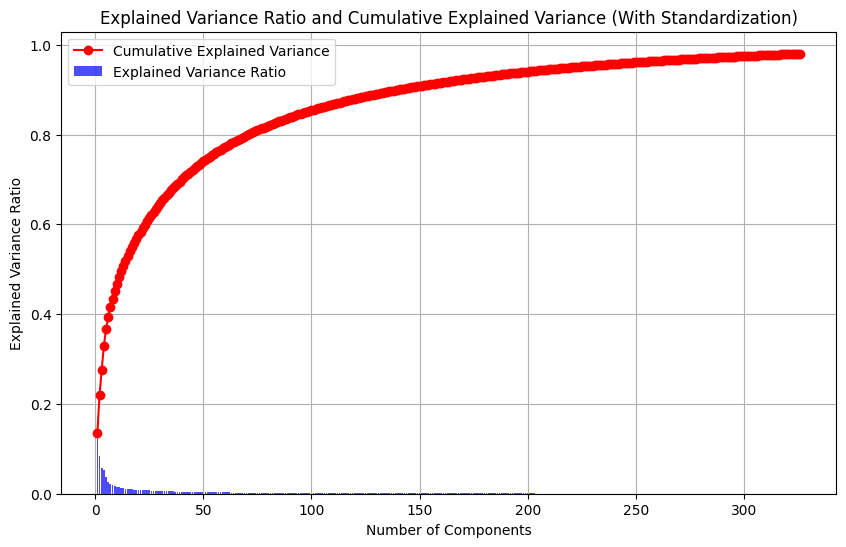

Total number of possible components: 1104
Number of components after PCA: 326 


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA with the desired number of components or variance threshold
n_components = 0.98  # Choose the desired cumulative explained variance
pca = PCA(n_components=n_components)


# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(reshaped_data)

X_pca = pca.fit_transform(X_standardized)

# Check the explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_variance_ratio)

# Generate the number of components
num_components = len(explained_variance_ratio)
total_possible_components = X_standardized.shape[1]

# Plot the explained variance ratio and cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_components + 1), explained_variance_ratio, label='Explained Variance Ratio', alpha=0.7, color='b')
plt.plot(range(1, num_components + 1), cumulative_explained_variance_ratio, label='Cumulative Explained Variance', color='r', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance (With Standardization)')
plt.legend()
plt.grid(True)

plt.show()

print(f'Total number of possible components: {total_possible_components}')
print(f'Number of components after PCA: {num_components} ')

## PCA Without Standardization

Explained variance ratio: [0.64375006 0.17795239 0.0613644  0.05275092 0.03138305 0.01783875]


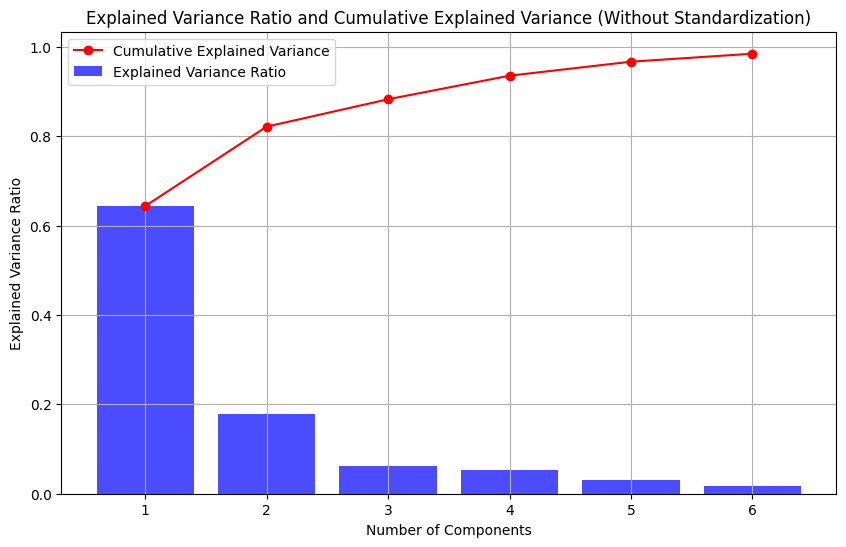

Total number of possible components: 1104
Number of components after PCA: 6 


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA with the desired number of components or variance threshold
n_components = 0.98  # Choose the desired cumulative explained variance
pca = PCA(n_components=n_components)

X_pca_without = pca.fit_transform(reshaped_data)

# Check the explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_variance_ratio)

# Generate the number of components
num_components = len(explained_variance_ratio)
total_possible_components = reshaped_data.shape[1]

# Plot the explained variance ratio and cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_components + 1), explained_variance_ratio, label='Explained Variance Ratio', alpha=0.7, color='b')
plt.plot(range(1, num_components + 1), cumulative_explained_variance_ratio, label='Cumulative Explained Variance', color='r', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio and Cumulative Explained Variance (Without Standardization)')
plt.legend()
plt.grid(True)

plt.show()

print(f'Total number of possible components: {total_possible_components}')
print(f'Number of components after PCA: {num_components} ')

## Correlation Matrix

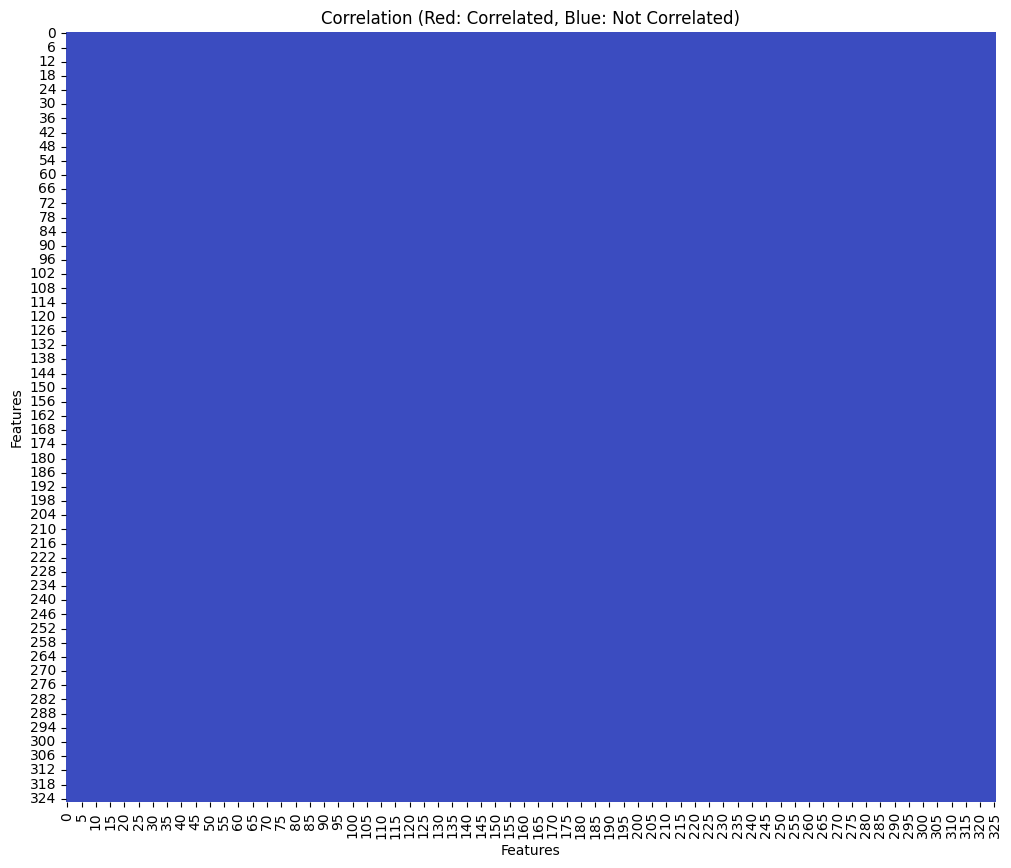

There are no correlation between features


In [90]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the original features
correlation_matrix = np.corrcoef(X_pca, rowvar=False)

# Create a binary matrix indicating correlation (1) or no correlation (0) excluding self-correlations
binary_matrix = np.abs(correlation_matrix) > 0.1  # Adjust the threshold as needed

# Set the diagonal (self-correlations) to 0
np.fill_diagonal(binary_matrix, 0)

# Visualize the binary matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(binary_matrix, annot=False, cmap='coolwarm', cbar=False)
plt.title('Correlation (Red: Correlated, Blue: Not Correlated)')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

print("There are no correlation between features")

# Save features to csv

In [91]:
FeaturesWithout = pd.DataFrame(X_pca_without)
FeaturesWithout['labels'] = Y
FeaturesWithout.to_csv('csv/new/darryl_6-PCA.csv', index=False)

In [92]:
Features = pd.DataFrame(X_pca)
Features['labels'] = Y
Features.to_csv('csv/new/darryl_326-PCA.csv', index=False)